In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os

## Define FCN16s model for deconvolution layers

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [3]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [4]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [5]:
batch_size = 12
epochs     = 100  #500
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 5
gamma      = 0.5
model_use  = "box_gan_LAMDAID_1" # "unity" "histogram" "box_gan"
save_name = "box_gan_LAMDAID_1"
n_class = 21

## Define path, directory trainning environment

In [6]:
# get data
data_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN", model_use)
if not os.path.exists(data_dir):
    print("Data not found!")
val_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/real")
if not os.path.exists(val_dir):
    print("Validation Data not found!")
test_dir  = os.path.join("/media/arg_ws3/5E703E3A703E18EB/data/mm_FCN/", model_use)
if not os.path.exists(test_dir):
    print("Validation Data not found!")
# create dir for model
model_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/mm_fcn/models", save_name)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# create dir for score
score_dir = os.path.join("/media/arg_ws3/5E703E3A703E18EB/research/mm_fcn/scores", save_name)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
#use_gpu = False
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 10.514808654785156


Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.



In [13]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w
brand_class = ['3m', 'andes', 'cocacola', 'crayola', 'folgers','heineken','hunts','kellogg','kleenex',\
               'kotex','libava','macadamia','milo','mm','pocky','raisins','stax','swissmiss','vanish','viva']
class product_dataset(Dataset):

    def __init__(self, csv_file, phase, n_class=n_class, flip_rate=0.):
        self.data      = pd.read_csv(csv_file)
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        self.phase = phase
        if self.phase == 'train':
            self.flip_rate = 0.5

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name   = self.data.iloc[idx, 0]
        label_name = self.data.iloc[idx, 1]
        if self.phase == 'train':
            img        = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
            label      = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
            #print(os.path.join(data_dir, img_name))
        elif self.phase == 'test':
            img        = cv2.imread(os.path.join(test_dir, img_name),cv2.IMREAD_UNCHANGED)
            label      = cv2.imread(os.path.join(test_dir, label_name), cv2.IMREAD_GRAYSCALE)
        else:
            img        = cv2.imread(os.path.join(val_dir, img_name),cv2.IMREAD_UNCHANGED)
            label      = cv2.imread(os.path.join(val_dir, label_name), cv2.IMREAD_GRAYSCALE)
            #print(os.path.join(val_dir, label_name))
        origin_img = img
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        
        '''for i in range(n_class - 1):
            if brand_class[i] in img_name:
                target[i+1][label != 0] = 1
                label[label != 0] = i+1
                #print(brand_class[i], img_name,label_name)'''
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))
        
 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img}

        return sample

## Define dataloader and optimizer

In [14]:
# initial dataloader for trainning and validation
train_file = os.path.join(data_dir, "train_with_box_all.csv")
val_file   = os.path.join(val_dir, "test.csv")
test_file  = os.path.join(test_dir, "test_with_box_all.csv")
train_data = product_dataset(csv_file = train_file, phase = 'train')
val_data   = product_dataset(csv_file = val_file, phase = 'val', flip_rate = 0)
test_data  = product_dataset(csv_file = test_file, phase = 'test', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 4, num_workers = 0)
test_loader = DataLoader(test_data, batch_size = 4, num_workers = 0)

dataiter = iter(val_loader)
testiter = iter(test_loader)

# define loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr = lr, momentum = momentum, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Train

In [13]:
def train():
    for epoch in range(epochs):
        fcn_model.train()
        scheduler.step()
        configs    = "FCNs_{}_batch{}_epoch{}_RMSprop_lr{}"\
            .format(model_use, batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        
        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['Y'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch+1, iter, loss.item()))
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 1 == 0:
            torch.save(fcn_model.state_dict(),model_path + '.pkl')

        val(epoch)

## Evaluation

In [15]:
def val(epoch):
    fcn_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()

        N, _, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('epoch:'+ str(epoch) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('epoch:'+ str(epoch) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('epoch:'+ str(epoch) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [15]:
train()

epoch1, iter0, loss: 0.6925056576728821
epoch1, iter10, loss: 0.6778578162193298
epoch1, iter20, loss: 0.6740193963050842
epoch1, iter30, loss: 0.6701598763465881
epoch1, iter40, loss: 0.6690642237663269
epoch1, iter50, loss: 0.6656683087348938
epoch1, iter60, loss: 0.6606497168540955
epoch1, iter70, loss: 0.6615276336669922
epoch1, iter80, loss: 0.6586209535598755
epoch1, iter90, loss: 0.6576176285743713
epoch1, iter100, loss: 0.6540116667747498
epoch1, iter110, loss: 0.6513070464134216
epoch1, iter120, loss: 0.6502017974853516
epoch1, iter130, loss: 0.6470025181770325
epoch1, iter140, loss: 0.6459764242172241
epoch1, iter150, loss: 0.6452304720878601
epoch1, iter160, loss: 0.6431059241294861
epoch1, iter170, loss: 0.6405218243598938
epoch1, iter180, loss: 0.6376442313194275
epoch1, iter190, loss: 0.635831356048584
epoch1, iter200, loss: 0.6328672170639038
epoch1, iter210, loss: 0.6307030320167542
epoch1, iter220, loss: 0.6297611594200134
epoch1, iter230, loss: 0.6269060969352722
epoc

epoch1, iter1920, loss: 0.17144402861595154
epoch1, iter1930, loss: 0.16812856495380402
epoch1, iter1940, loss: 0.1662420779466629
epoch1, iter1950, loss: 0.16566473245620728
epoch1, iter1960, loss: 0.1633899211883545
epoch1, iter1970, loss: 0.1608811616897583
epoch1, iter1980, loss: 0.15921173989772797
epoch1, iter1990, loss: 0.15788652002811432
epoch1, iter2000, loss: 0.15523205697536469
epoch1, iter2010, loss: 0.15466070175170898
epoch1, iter2020, loss: 0.15241758525371552
epoch1, iter2030, loss: 0.1509140133857727
epoch1, iter2040, loss: 0.1488839089870453
epoch1, iter2050, loss: 0.14677347242832184
epoch1, iter2060, loss: 0.14469313621520996
epoch1, iter2070, loss: 0.14261096715927124
epoch1, iter2080, loss: 0.1411866396665573
epoch1, iter2090, loss: 0.14076636731624603
epoch1, iter2100, loss: 0.13895313441753387
epoch1, iter2110, loss: 0.1375112235546112
epoch1, iter2120, loss: 0.13537167012691498
epoch1, iter2130, loss: 0.13204728066921234
epoch1, iter2140, loss: 0.1316609382629

epoch1, iter3780, loss: 0.014434408396482468
epoch1, iter3790, loss: 0.01650167442858219
epoch1, iter3800, loss: 0.013907840475440025
epoch1, iter3810, loss: 0.01866319589316845
epoch1, iter3820, loss: 0.014248071238398552
epoch1, iter3830, loss: 0.016837595030665398
epoch1, iter3840, loss: 0.015565592795610428
epoch1, iter3850, loss: 0.013580532744526863
epoch1, iter3860, loss: 0.01553935743868351
epoch1, iter3870, loss: 0.017487816512584686
epoch1, iter3880, loss: 0.01743222586810589
epoch1, iter3890, loss: 0.01708756759762764
epoch1, iter3900, loss: 0.014641045592725277
epoch1, iter3910, loss: 0.01495281606912613
epoch1, iter3920, loss: 0.020008109509944916
epoch1, iter3930, loss: 0.011637600138783455
epoch1, iter3940, loss: 0.014111153781414032
epoch1, iter3950, loss: 0.014902699738740921
epoch1, iter3960, loss: 0.01135055348277092
epoch1, iter3970, loss: 0.012430484406650066
epoch1, iter3980, loss: 0.01332993432879448
epoch1, iter3990, loss: 0.012249313294887543
epoch1, iter4000, 

epoch1, iter5610, loss: 0.003042398951947689
epoch1, iter5620, loss: 0.002823282964527607
epoch1, iter5630, loss: 0.0040855384431779385
epoch1, iter5640, loss: 0.003202698426321149
epoch1, iter5650, loss: 0.0030595220159739256
epoch1, iter5660, loss: 0.0025243067648261786
epoch1, iter5670, loss: 0.002613835036754608
epoch1, iter5680, loss: 0.003375209867954254
epoch1, iter5690, loss: 0.0032186470925807953
epoch1, iter5700, loss: 0.006511778105050325
epoch1, iter5710, loss: 0.002840721048414707
epoch1, iter5720, loss: 0.0027327765710651875
epoch1, iter5730, loss: 0.007022183854132891
epoch1, iter5740, loss: 0.004241551738232374
epoch1, iter5750, loss: 0.003469181014224887
epoch1, iter5760, loss: 0.0026199074927717447
epoch1, iter5770, loss: 0.0018152069533243775
epoch1, iter5780, loss: 0.002534305676817894
epoch1, iter5790, loss: 0.004307443741708994
epoch1, iter5800, loss: 0.002377504715695977
epoch1, iter5810, loss: 0.004886782728135586
epoch1, iter5820, loss: 0.0023007893469184637
ep

epoch2, iter1280, loss: 0.00220687547698617
epoch2, iter1290, loss: 0.0014267981750890613
epoch2, iter1300, loss: 0.0012812287313863635
epoch2, iter1310, loss: 0.0015667093684896827
epoch2, iter1320, loss: 0.002032174728810787
epoch2, iter1330, loss: 0.00128989911172539
epoch2, iter1340, loss: 0.0023280370514839888
epoch2, iter1350, loss: 0.0016367330681532621
epoch2, iter1360, loss: 0.0016788638895377517
epoch2, iter1370, loss: 0.002274170285090804
epoch2, iter1380, loss: 0.0008583288872614503
epoch2, iter1390, loss: 0.0051435246132314205
epoch2, iter1400, loss: 0.001170433941297233
epoch2, iter1410, loss: 0.0011362908408045769
epoch2, iter1420, loss: 0.0007937703048810363
epoch2, iter1430, loss: 0.001388672273606062
epoch2, iter1440, loss: 0.001374449348077178
epoch2, iter1450, loss: 0.001653706538490951
epoch2, iter1460, loss: 0.0031618669163435698
epoch2, iter1470, loss: 0.0008470323518849909
epoch2, iter1480, loss: 0.0015524703776463866
epoch2, iter1490, loss: 0.002104120561853051

epoch2, iter3080, loss: 0.0010421483311802149
epoch2, iter3090, loss: 0.0007334942347370088
epoch2, iter3100, loss: 0.0007126681157387793
epoch2, iter3110, loss: 0.0006896259146742523
epoch2, iter3120, loss: 0.000671654473990202
epoch2, iter3130, loss: 0.0009988564997911453
epoch2, iter3140, loss: 0.0003809341578744352
epoch2, iter3150, loss: 0.0005249116220511496
epoch2, iter3160, loss: 0.0004081049410160631
epoch2, iter3170, loss: 0.0003898338763974607
epoch2, iter3180, loss: 0.0006137391901575029
epoch2, iter3190, loss: 0.0006618773913942277
epoch2, iter3200, loss: 0.0005969761987216771
epoch2, iter3210, loss: 0.0004877244937233627
epoch2, iter3220, loss: 0.0005839461809955537
epoch2, iter3230, loss: 0.0010272359941154718
epoch2, iter3240, loss: 0.001115881372243166
epoch2, iter3250, loss: 0.0012643225491046906
epoch2, iter3260, loss: 0.0005883618141524494
epoch2, iter3270, loss: 0.00510199973359704
epoch2, iter3280, loss: 0.00163663097191602
epoch2, iter3290, loss: 0.00259249657392

epoch2, iter4870, loss: 0.0006337790400721133
epoch2, iter4880, loss: 0.00041206361493095756
epoch2, iter4890, loss: 0.0004397742450237274
epoch2, iter4900, loss: 0.00038153419154696167
epoch2, iter4910, loss: 0.00042394225602038205
epoch2, iter4920, loss: 0.0011145120952278376
epoch2, iter4930, loss: 0.00505579961463809
epoch2, iter4940, loss: 0.00040535462903790176
epoch2, iter4950, loss: 0.0007019046461209655
epoch2, iter4960, loss: 0.0003411729703657329
epoch2, iter4970, loss: 0.0021140133030712605
epoch2, iter4980, loss: 0.0009355638176202774
epoch2, iter4990, loss: 0.00045282667269930243
epoch2, iter5000, loss: 0.0002642897889018059
epoch2, iter5010, loss: 0.00033581728348508477
epoch2, iter5020, loss: 0.000446282239863649
epoch2, iter5030, loss: 0.0006196036119945347
epoch2, iter5040, loss: 0.000287320843199268
epoch2, iter5050, loss: 0.0003991615667473525
epoch2, iter5060, loss: 0.0003895285481121391
epoch2, iter5070, loss: 0.00045780924847349524
epoch2, iter5080, loss: 0.00029

epoch3, iter580, loss: 0.0008563419105485082
epoch3, iter590, loss: 0.000349771959008649
epoch3, iter600, loss: 0.0002696577284950763
epoch3, iter610, loss: 0.0009888423373922706
epoch3, iter620, loss: 0.0010782773606479168
epoch3, iter630, loss: 0.00023144057195167989
epoch3, iter640, loss: 0.0004163886478636414
epoch3, iter650, loss: 0.0004104528925381601
epoch3, iter660, loss: 0.0005074748187325895
epoch3, iter670, loss: 0.0002782148076221347
epoch3, iter680, loss: 0.001610803185030818
epoch3, iter690, loss: 0.0030331439338624477
epoch3, iter700, loss: 0.0007547649438492954
epoch3, iter710, loss: 0.00044368059025146067
epoch3, iter720, loss: 0.0018302808748558164
epoch3, iter730, loss: 0.0004019778862129897
epoch3, iter740, loss: 0.0004072819428984076
epoch3, iter750, loss: 0.0004264086310286075
epoch3, iter760, loss: 0.0002777739427983761
epoch3, iter770, loss: 0.00024054624373093247
epoch3, iter780, loss: 0.0012575347209349275
epoch3, iter790, loss: 0.0004408077511470765
epoch3, i

epoch3, iter2370, loss: 0.00040662509854882956
epoch3, iter2380, loss: 0.00025737378746271133
epoch3, iter2390, loss: 0.00027741570374928415
epoch3, iter2400, loss: 0.00038289226358756423
epoch3, iter2410, loss: 0.0007421041373163462
epoch3, iter2420, loss: 0.0004929302958771586
epoch3, iter2430, loss: 0.0002533140650484711
epoch3, iter2440, loss: 0.0005498850950971246
epoch3, iter2450, loss: 0.0002307743561686948
epoch3, iter2460, loss: 0.00023892277386039495
epoch3, iter2470, loss: 0.00022836503922007978
epoch3, iter2480, loss: 0.0003370887425262481
epoch3, iter2490, loss: 0.00029544284916482866
epoch3, iter2500, loss: 0.0005405850242823362
epoch3, iter2510, loss: 0.00027518541901372373
epoch3, iter2520, loss: 0.0002490256156306714
epoch3, iter2530, loss: 0.018544582650065422
epoch3, iter2540, loss: 0.003232843242585659
epoch3, iter2550, loss: 0.00035943760303780437
epoch3, iter2560, loss: 0.0007191094337031245
epoch3, iter2570, loss: 0.0005285857478156686
epoch3, iter2580, loss: 0.0

epoch3, iter4140, loss: 0.00037280324613675475
epoch3, iter4150, loss: 0.000328430556692183
epoch3, iter4160, loss: 0.00020258952281437814
epoch3, iter4170, loss: 0.0002494170912541449
epoch3, iter4180, loss: 0.00020400667563080788
epoch3, iter4190, loss: 0.00038069149013608694
epoch3, iter4200, loss: 0.0004325962800066918
epoch3, iter4210, loss: 0.00027744797989726067
epoch3, iter4220, loss: 0.00022584310499951243
epoch3, iter4230, loss: 0.0002564907190389931
epoch3, iter4240, loss: 0.00031395137193612754
epoch3, iter4250, loss: 0.0002375529584242031
epoch3, iter4260, loss: 0.0003124875947833061
epoch3, iter4270, loss: 0.002861934946849942
epoch3, iter4280, loss: 0.0007899738848209381
epoch3, iter4290, loss: 0.0004555797204375267
epoch3, iter4300, loss: 0.0003362892894074321
epoch3, iter4310, loss: 0.0006615466554649174
epoch3, iter4320, loss: 0.00022763392189517617
epoch3, iter4330, loss: 0.00024465436581522226
epoch3, iter4340, loss: 0.000559172302018851
epoch3, iter4350, loss: 0.00

epoch4, iter0, loss: 0.0003330961335450411
epoch4, iter10, loss: 0.00026827602414414287
epoch4, iter20, loss: 0.00031597010092809796
epoch4, iter30, loss: 0.0003975413565058261
epoch4, iter40, loss: 0.000340922677423805
epoch4, iter50, loss: 0.0002926657034549862
epoch4, iter60, loss: 0.0003882998717017472
epoch4, iter70, loss: 0.03571685031056404
epoch4, iter80, loss: 0.0016326465411111712
epoch4, iter90, loss: 0.0007990170270204544
epoch4, iter100, loss: 0.00041363612399436533
epoch4, iter110, loss: 0.00032580154947936535
epoch4, iter120, loss: 0.000440126663306728
epoch4, iter130, loss: 0.0003414750099182129
epoch4, iter140, loss: 0.0004017447936348617
epoch4, iter150, loss: 0.0006961105391383171
epoch4, iter160, loss: 0.0006995665025897324
epoch4, iter170, loss: 0.00041032832814380527
epoch4, iter180, loss: 0.000601557083427906
epoch4, iter190, loss: 0.0003877707349602133
epoch4, iter200, loss: 0.0004937340854667127
epoch4, iter210, loss: 0.0002629162627272308
epoch4, iter220, loss

epoch4, iter1800, loss: 0.00021409646433312446
epoch4, iter1810, loss: 0.000238854976487346
epoch4, iter1820, loss: 0.0003203288943041116
epoch4, iter1830, loss: 0.0002293475263286382
epoch4, iter1840, loss: 0.0016202281694859266
epoch4, iter1850, loss: 0.0006744330166839063
epoch4, iter1860, loss: 0.0008658297592774034
epoch4, iter1870, loss: 0.008259744383394718
epoch4, iter1880, loss: 0.0011734506115317345
epoch4, iter1890, loss: 0.0005098722176626325
epoch4, iter1900, loss: 0.0020816049072891474
epoch4, iter1910, loss: 0.0003111861296929419
epoch4, iter1920, loss: 0.0006501877214759588
epoch4, iter1930, loss: 0.0002532434882596135
epoch4, iter1940, loss: 0.00026337013696320355
epoch4, iter1950, loss: 0.00022631547471974045
epoch4, iter1960, loss: 0.00022145725961308926
epoch4, iter1970, loss: 0.001402118243277073
epoch4, iter1980, loss: 0.00023389753187075257
epoch4, iter1990, loss: 0.00020207371562719345
epoch4, iter2000, loss: 0.0005153907695785165
epoch4, iter2010, loss: 0.00020

epoch4, iter3570, loss: 0.0003226019034627825
epoch4, iter3580, loss: 0.00037819708813913167
epoch4, iter3590, loss: 0.00018153390556108207
epoch4, iter3600, loss: 0.00020811846479773521
epoch4, iter3610, loss: 0.00026068813167512417
epoch4, iter3620, loss: 0.0010145455598831177
epoch4, iter3630, loss: 0.0010393180418759584
epoch4, iter3640, loss: 0.0006361723644658923
epoch4, iter3650, loss: 0.00032262440072372556
epoch4, iter3660, loss: 0.00030196033185347915
epoch4, iter3670, loss: 0.0014400591608136892
epoch4, iter3680, loss: 0.0002507708268240094
epoch4, iter3690, loss: 0.0003009765059687197
epoch4, iter3700, loss: 0.00033681586501188576
epoch4, iter3710, loss: 0.0008650711388327181
epoch4, iter3720, loss: 0.0005072233616374433
epoch4, iter3730, loss: 0.005722691770642996
epoch4, iter3740, loss: 0.0013231798075139523
epoch4, iter3750, loss: 0.0007062364020384848
epoch4, iter3760, loss: 0.00023434520699083805
epoch4, iter3770, loss: 0.0005475822254084051
epoch4, iter3780, loss: 0.0

epoch4, iter5340, loss: 0.0002899886458180845
epoch4, iter5350, loss: 0.00024375537759624422
epoch4, iter5360, loss: 0.00018053942767437547
epoch4, iter5370, loss: 0.0004562711692415178
epoch4, iter5380, loss: 0.00022028789680916816
epoch4, iter5390, loss: 0.00015970892854966223
epoch4, iter5400, loss: 0.013456825166940689
epoch4, iter5410, loss: 0.00076528504723683
epoch4, iter5420, loss: 0.002417471259832382
epoch4, iter5430, loss: 0.00044062445522286
epoch4, iter5440, loss: 0.00027060997672379017
epoch4, iter5450, loss: 0.0005962554714642465
epoch4, iter5460, loss: 0.00036095594987273216
epoch4, iter5470, loss: 0.00025518075563013554
epoch4, iter5480, loss: 0.0002727774262893945
epoch4, iter5490, loss: 0.00031241928809322417
epoch4, iter5500, loss: 0.0010947457049041986
epoch4, iter5510, loss: 0.0015909106004983187
epoch4, iter5520, loss: 0.00020684360060840845
epoch4, iter5530, loss: 0.0003899452858604491
epoch4, iter5540, loss: 0.00033808883745223284
epoch4, iter5550, loss: 0.0003

epoch5, iter1030, loss: 0.0002952266077045351
epoch5, iter1040, loss: 0.0005049993051216006
epoch5, iter1050, loss: 0.0001754988479660824
epoch5, iter1060, loss: 0.00040190989966504276
epoch5, iter1070, loss: 0.00018241799261886626
epoch5, iter1080, loss: 0.00046352145727723837
epoch5, iter1090, loss: 0.0019197539659217
epoch5, iter1100, loss: 0.00040462787728756666
epoch5, iter1110, loss: 0.00034448792575858533
epoch5, iter1120, loss: 0.00023964897263795137
epoch5, iter1130, loss: 0.0002498176181688905
epoch5, iter1140, loss: 0.00016706553287804127
epoch5, iter1150, loss: 0.00016306481848005205
epoch5, iter1160, loss: 0.0002555415267124772
epoch5, iter1170, loss: 0.0002818280481733382
epoch5, iter1180, loss: 0.0017759002512320876
epoch5, iter1190, loss: 0.008000039495527744
epoch5, iter1200, loss: 0.0005366600817069411
epoch5, iter1210, loss: 0.00038198562106117606
epoch5, iter1220, loss: 0.000244191091042012
epoch5, iter1230, loss: 0.00019441332551650703
epoch5, iter1240, loss: 0.000

epoch5, iter2800, loss: 0.0001769787777448073
epoch5, iter2810, loss: 0.00016500128549523652
epoch5, iter2820, loss: 0.00016573343600612134
epoch5, iter2830, loss: 0.0002600250008981675
epoch5, iter2840, loss: 0.0002530724450480193
epoch5, iter2850, loss: 0.0003730296157300472
epoch5, iter2860, loss: 0.00046109670074656606
epoch5, iter2870, loss: 0.0025328996125608683
epoch5, iter2880, loss: 0.001972926314920187
epoch5, iter2890, loss: 0.0009539143065921962
epoch5, iter2900, loss: 0.0003713142068590969
epoch5, iter2910, loss: 0.00019566855917219073
epoch5, iter2920, loss: 0.0005392193561419845
epoch5, iter2930, loss: 0.0004127704305574298
epoch5, iter2940, loss: 0.00020803323423024267
epoch5, iter2950, loss: 0.00024673319421708584
epoch5, iter2960, loss: 0.0005373802268877625
epoch5, iter2970, loss: 0.00021129577362444252
epoch5, iter2980, loss: 0.0002318063925486058
epoch5, iter2990, loss: 0.00017960599507205188
epoch5, iter3000, loss: 0.00020736434089485556
epoch5, iter3010, loss: 0.

epoch5, iter4570, loss: 0.00027459897683002055
epoch5, iter4580, loss: 0.00052162742940709
epoch5, iter4590, loss: 0.0002623526379466057
epoch5, iter4600, loss: 0.0007481371285393834
epoch5, iter4610, loss: 0.00021472552907653153
epoch5, iter4620, loss: 0.00020014861365780234
epoch5, iter4630, loss: 0.0002939265104942024
epoch5, iter4640, loss: 0.0015093102119863033
epoch5, iter4650, loss: 0.0003503912885207683
epoch5, iter4660, loss: 0.00019828580843750387
epoch5, iter4670, loss: 0.0001874579902505502
epoch5, iter4680, loss: 0.00019014750432688743
epoch5, iter4690, loss: 0.00023791927378624678
epoch5, iter4700, loss: 0.00023996220261324197
epoch5, iter4710, loss: 0.00029558647656813264
epoch5, iter4720, loss: 0.0002714205184020102
epoch5, iter4730, loss: 0.0002711986016947776
epoch5, iter4740, loss: 0.0002685306826606393
epoch5, iter4750, loss: 0.00019760566647164524
epoch5, iter4760, loss: 0.00017701336764730513
epoch5, iter4770, loss: 0.00029094412457197905
epoch5, iter4780, loss: 0

epoch6, iter240, loss: 0.00015192183491308242
epoch6, iter250, loss: 0.00017916705110110343
epoch6, iter260, loss: 0.00015242112567648292
epoch6, iter270, loss: 0.00015931404777802527
epoch6, iter280, loss: 0.0001463180669816211
epoch6, iter290, loss: 0.0004265736788511276
epoch6, iter300, loss: 0.00015053908282425255
epoch6, iter310, loss: 0.00022517915931530297
epoch6, iter320, loss: 0.00016923273506108671
epoch6, iter330, loss: 0.0001842925266828388
epoch6, iter340, loss: 0.0001672021026024595
epoch6, iter350, loss: 0.00017351494170725346
epoch6, iter360, loss: 0.0001186411755043082
epoch6, iter370, loss: 0.00018522028403822333
epoch6, iter380, loss: 0.00018786675354931504
epoch6, iter390, loss: 0.00021797210501972586
epoch6, iter400, loss: 0.0002380165533395484
epoch6, iter410, loss: 0.00022996007464826107
epoch6, iter420, loss: 0.00042814252083189785
epoch6, iter430, loss: 0.0002316675236215815
epoch6, iter440, loss: 0.0001554896152811125
epoch6, iter450, loss: 0.00019262921705376

epoch6, iter2020, loss: 0.00033291318686679006
epoch6, iter2030, loss: 0.00018907329649664462
epoch6, iter2040, loss: 0.0007031614659354091
epoch6, iter2050, loss: 0.0004558386863209307
epoch6, iter2060, loss: 0.00017702975310385227
epoch6, iter2070, loss: 0.0001848110114224255
epoch6, iter2080, loss: 0.00016918662004172802
epoch6, iter2090, loss: 0.00033705096575431526
epoch6, iter2100, loss: 0.0002671190886758268
epoch6, iter2110, loss: 0.00014404083776753396
epoch6, iter2120, loss: 0.00017851659504231066
epoch6, iter2130, loss: 0.00016320450231432915
epoch6, iter2140, loss: 0.00022685450676362962
epoch6, iter2150, loss: 0.00016223105194512755
epoch6, iter2160, loss: 0.00012357626110315323
epoch6, iter2170, loss: 0.00019185386190656573
epoch6, iter2180, loss: 0.0012479599099606276
epoch6, iter2190, loss: 0.0001757724239723757
epoch6, iter2200, loss: 0.0001253575464943424
epoch6, iter2210, loss: 0.00015696576156187803
epoch6, iter2220, loss: 0.00014823635865468532
epoch6, iter2230, lo

epoch6, iter3780, loss: 0.00015516369603574276
epoch6, iter3790, loss: 0.0002166862686863169
epoch6, iter3800, loss: 0.0014077211963012815
epoch6, iter3810, loss: 0.0002836866187863052
epoch6, iter3820, loss: 0.00016886088997125626
epoch6, iter3830, loss: 0.00030623353086411953
epoch6, iter3840, loss: 0.0002023658889811486
epoch6, iter3850, loss: 0.00019663995772134513
epoch6, iter3860, loss: 0.00022709128097631037
epoch6, iter3870, loss: 0.00016208147280849516
epoch6, iter3880, loss: 0.00026784971123561263
epoch6, iter3890, loss: 0.00012277877249289304
epoch6, iter3900, loss: 0.00017122305871453136
epoch6, iter3910, loss: 0.00015553280536551028
epoch6, iter3920, loss: 0.00017482576367910951
epoch6, iter3930, loss: 0.00011843661195598543
epoch6, iter3940, loss: 0.00012379522377159446
epoch6, iter3950, loss: 0.00047583808191120625
epoch6, iter3960, loss: 0.00017927188309840858
epoch6, iter3970, loss: 0.0001462435902794823
epoch6, iter3980, loss: 0.0002132713852915913
epoch6, iter3990, l

epoch6, iter5540, loss: 0.00015345292922575027
epoch6, iter5550, loss: 0.00015912679373286664
epoch6, iter5560, loss: 0.00013056628813501447
epoch6, iter5570, loss: 0.00039265325176529586
epoch6, iter5580, loss: 0.00013423430209513754
epoch6, iter5590, loss: 0.00017944439605344087
epoch6, iter5600, loss: 0.00027220218908041716
epoch6, iter5610, loss: 0.00040035555139184
epoch6, iter5620, loss: 0.0003761598782148212
epoch6, iter5630, loss: 0.00031825550831854343
epoch6, iter5640, loss: 0.0001935447216965258
epoch6, iter5650, loss: 0.00015568907838314772
epoch6, iter5660, loss: 0.00018184061627835035
epoch6, iter5670, loss: 0.00015447325131390244
epoch6, iter5680, loss: 0.00014509723405353725
epoch6, iter5690, loss: 0.00014350871788337827
epoch6, iter5700, loss: 0.00028868881054222584
epoch6, iter5710, loss: 0.00014465334243141115
epoch6, iter5720, loss: 0.00030097668059170246
epoch6, iter5730, loss: 0.0001478152407798916
epoch6, iter5740, loss: 0.0004992709727957845
epoch6, iter5750, lo

epoch7, iter1240, loss: 0.001882872893474996
epoch7, iter1250, loss: 0.0005697146989405155
epoch7, iter1260, loss: 0.00018665680545382202
epoch7, iter1270, loss: 0.00015946364146657288
epoch7, iter1280, loss: 0.00021625302906613797
epoch7, iter1290, loss: 0.00018462640582583845
epoch7, iter1300, loss: 0.00015766176511533558
epoch7, iter1310, loss: 0.00015989967505447567
epoch7, iter1320, loss: 0.00017673672118689865
epoch7, iter1330, loss: 0.00014169166388455778
epoch7, iter1340, loss: 0.0002441905380692333
epoch7, iter1350, loss: 0.0002213217521784827
epoch7, iter1360, loss: 0.00021658565674442798
epoch7, iter1370, loss: 0.00023919998784549534
epoch7, iter1380, loss: 0.00023803790099918842
epoch7, iter1390, loss: 0.00015493793762288988
epoch7, iter1400, loss: 0.000174677959876135
epoch7, iter1410, loss: 0.00017213207320310175
epoch7, iter1420, loss: 0.00012488984793890268
epoch7, iter1430, loss: 0.00021409908367786556
epoch7, iter1440, loss: 0.00015548114606644958
epoch7, iter1450, lo

epoch7, iter3010, loss: 0.00013969611609354615
epoch7, iter3020, loss: 0.0003203080559615046
epoch7, iter3030, loss: 0.0001226961612701416
epoch7, iter3040, loss: 0.00019067256653215736
epoch7, iter3050, loss: 0.0001463370572309941
epoch7, iter3060, loss: 0.0001908713165903464
epoch7, iter3070, loss: 0.0006626736139878631
epoch7, iter3080, loss: 0.00017428731371182948
epoch7, iter3090, loss: 0.00016009146929718554
epoch7, iter3100, loss: 0.00014238474250305444
epoch7, iter3110, loss: 0.00016324354510288686
epoch7, iter3120, loss: 0.00016790360677987337
epoch7, iter3130, loss: 0.00021869341435376555
epoch7, iter3140, loss: 0.0003159107582177967
epoch7, iter3150, loss: 0.0001400025503244251
epoch7, iter3160, loss: 0.00015625548257958144
epoch7, iter3170, loss: 0.00011870152229676023
epoch7, iter3180, loss: 0.0003632602747529745
epoch7, iter3190, loss: 0.0002670236863195896
epoch7, iter3200, loss: 0.00014630392252001911
epoch7, iter3210, loss: 0.00019578573119360954
epoch7, iter3220, loss

epoch7, iter4770, loss: 0.00019483429787214845
epoch7, iter4780, loss: 0.00020168117771390826
epoch7, iter4790, loss: 0.00015131855616346002
epoch7, iter4800, loss: 0.00022632809123024344
epoch7, iter4810, loss: 0.0015337658114731312
epoch7, iter4820, loss: 0.0006579704349860549
epoch7, iter4830, loss: 0.00017336534801870584
epoch7, iter4840, loss: 0.00037834487739019096
epoch7, iter4850, loss: 0.00014608293713536114
epoch7, iter4860, loss: 0.00016093338490463793
epoch7, iter4870, loss: 0.0002148682251572609
epoch7, iter4880, loss: 0.00018082125461660326
epoch7, iter4890, loss: 0.00013913399016018957
epoch7, iter4900, loss: 0.00022644530690740794
epoch7, iter4910, loss: 0.00012630547280423343
epoch7, iter4920, loss: 0.003001360921189189
epoch7, iter4930, loss: 0.0003294629859738052
epoch7, iter4940, loss: 0.00021995340648572892
epoch7, iter4950, loss: 0.00016090688586700708
epoch7, iter4960, loss: 0.00015167750825639814
epoch7, iter4970, loss: 0.00016381824389100075
epoch7, iter4980, l

epoch8, iter410, loss: 0.0001525414118077606
epoch8, iter420, loss: 0.00021047177142463624
epoch8, iter430, loss: 0.00014197890413925052
epoch8, iter440, loss: 0.00016467009845655411
epoch8, iter450, loss: 0.00019282371795270592
epoch8, iter460, loss: 0.0001163884371635504
epoch8, iter470, loss: 0.00019849852833431214
epoch8, iter480, loss: 0.00014922766422387213
epoch8, iter490, loss: 0.00016645157302264124
epoch8, iter500, loss: 0.00014853430911898613
epoch8, iter510, loss: 0.00016926050011534244
epoch8, iter520, loss: 0.00025036168517544866
epoch8, iter530, loss: 0.00018857605755329132
epoch8, iter540, loss: 0.0002625937049742788
epoch8, iter550, loss: 0.00015765639545861632
epoch8, iter560, loss: 0.00012681487714871764
epoch8, iter570, loss: 0.0002560867869760841
epoch8, iter580, loss: 0.0004643193678930402
epoch8, iter590, loss: 0.00014829814608674496
epoch8, iter600, loss: 0.00028643448604270816
epoch8, iter610, loss: 0.00015330211317632347
epoch8, iter620, loss: 0.00013533665332

epoch8, iter2190, loss: 0.00016032246639952064
epoch8, iter2200, loss: 0.00018770352471619844
epoch8, iter2210, loss: 0.0003469722578302026
epoch8, iter2220, loss: 0.0001514177129138261
epoch8, iter2230, loss: 0.00017628165369387716
epoch8, iter2240, loss: 0.00022231097682379186
epoch8, iter2250, loss: 0.0001425355876563117
epoch8, iter2260, loss: 0.00014817649207543582
epoch8, iter2270, loss: 0.0001544498372823
epoch8, iter2280, loss: 0.00016397004947066307
epoch8, iter2290, loss: 0.00015285603876691312
epoch8, iter2300, loss: 0.00028815673431381583
epoch8, iter2310, loss: 0.00013341203157324344
epoch8, iter2320, loss: 0.0002765971585176885
epoch8, iter2330, loss: 0.00035776395816355944
epoch8, iter2340, loss: 0.000166451238328591
epoch8, iter2350, loss: 0.0001714473619358614
epoch8, iter2360, loss: 0.00022748064657207578
epoch8, iter2370, loss: 0.00013219846005085856
epoch8, iter2380, loss: 0.00011555331730050966
epoch8, iter2390, loss: 0.00019376225827727467
epoch8, iter2400, loss: 

epoch8, iter3950, loss: 0.0002739319170359522
epoch8, iter3960, loss: 0.00034153819433413446
epoch8, iter3970, loss: 0.00032745988573879004
epoch8, iter3980, loss: 0.00014886798453517258
epoch8, iter3990, loss: 0.00017321397899650037
epoch8, iter4000, loss: 0.00025545095559209585
epoch8, iter4010, loss: 0.00021552374528255314
epoch8, iter4020, loss: 0.00015703933604527265
epoch8, iter4030, loss: 0.0002494810032658279
epoch8, iter4040, loss: 0.00042318025953136384
epoch8, iter4050, loss: 0.00019650197646114975
epoch8, iter4060, loss: 0.00019644414715003222
epoch8, iter4070, loss: 0.00014425691915675998
epoch8, iter4080, loss: 0.00022118819470051676
epoch8, iter4090, loss: 0.0003454175603110343
epoch8, iter4100, loss: 0.00013692121137864888
epoch8, iter4110, loss: 0.00015580822946503758
epoch8, iter4120, loss: 0.0002637486904859543
epoch8, iter4130, loss: 0.00020616584515664726
epoch8, iter4140, loss: 0.00017979701806325465
epoch8, iter4150, loss: 0.00020412399317137897
epoch8, iter4160,

epoch8, iter5710, loss: 0.00014361627108883113
epoch8, iter5720, loss: 0.00016622396651655436
epoch8, iter5730, loss: 0.0001927115663420409
epoch8, iter5740, loss: 0.00015450896171387285
epoch8, iter5750, loss: 0.00015771690232213587
epoch8, iter5760, loss: 0.00013347297499421984
epoch8, iter5770, loss: 0.00019713322399184108
epoch8, iter5780, loss: 0.0005143459420651197
epoch8, iter5790, loss: 0.0001849072432378307
epoch8, iter5800, loss: 0.0001423764624632895
epoch8, iter5810, loss: 0.00019266556773800403
epoch8, iter5820, loss: 0.0001447876711608842
epoch8, iter5830, loss: 0.00022724844166077673
epoch8, iter5840, loss: 0.00015343315317295492
epoch8, iter5850, loss: 0.0001893169537652284
Finish epoch 7, time elapsed 11356.800152540207
epoch7, pix_acc: 0.9083787817525585, meanIoU: 0.08019597031966458, IoUs: [1.36482028e-01 7.26463104e-02 2.39712606e-04 1.03979299e-01
 2.34996860e-07 2.12685723e-02 1.28549174e-01 2.56781611e-01
 5.04485276e-03 6.11790971e-03 1.05065719e-01 1.46999987e-

epoch9, iter1340, loss: 0.00025225256104022264
epoch9, iter1350, loss: 0.00019267947936896235
epoch9, iter1360, loss: 0.00015186636301223189
epoch9, iter1370, loss: 0.00017638482677284628
epoch9, iter1380, loss: 0.00019613929907791317
epoch9, iter1390, loss: 0.0002309987467015162
epoch9, iter1400, loss: 0.0011426345445215702
epoch9, iter1410, loss: 0.00014843880489934236
epoch9, iter1420, loss: 0.0002637842553667724
epoch9, iter1430, loss: 0.0002033642231253907
epoch9, iter1440, loss: 0.00011872137838508934
epoch9, iter1450, loss: 0.00016728098853491247
epoch9, iter1460, loss: 0.00021981264580972493
epoch9, iter1470, loss: 0.0001390178658766672
epoch9, iter1480, loss: 0.00022653191990684718
epoch9, iter1490, loss: 0.00018062627350445837
epoch9, iter1500, loss: 0.00017497911176178604
epoch9, iter1510, loss: 0.00013636573567055166
epoch9, iter1520, loss: 0.0001682424481259659
epoch9, iter1530, loss: 0.00045598752330988646
epoch9, iter1540, loss: 0.0001315485715167597
epoch9, iter1550, lo

epoch9, iter3100, loss: 0.0001663233560975641
epoch9, iter3110, loss: 0.00019654410425573587
epoch9, iter3120, loss: 0.0001263201847905293
epoch9, iter3130, loss: 0.0001483374071540311
epoch9, iter3140, loss: 0.0001249385968549177
epoch9, iter3150, loss: 0.0008180220611393452
epoch9, iter3160, loss: 0.0002617484424263239
epoch9, iter3170, loss: 0.00018235058814752847
epoch9, iter3180, loss: 0.00019645827705971897
epoch9, iter3190, loss: 0.0001927786652231589
epoch9, iter3200, loss: 0.00020378032058943063
epoch9, iter3210, loss: 0.0002004521229537204
epoch9, iter3220, loss: 0.00015801464905962348
epoch9, iter3230, loss: 0.00013907748507335782
epoch9, iter3240, loss: 0.00012455829710233957
epoch9, iter3250, loss: 0.00017194930114783347
epoch9, iter3260, loss: 0.00013566574489232153
epoch9, iter3270, loss: 0.000131008040625602
epoch9, iter3280, loss: 0.00016558826609980315
epoch9, iter3290, loss: 0.00013576823403127491
epoch9, iter3300, loss: 0.00014227190695237368
epoch9, iter3310, loss:

epoch9, iter4870, loss: 0.00014191670925356448
epoch9, iter4880, loss: 0.00014950009062886238
epoch9, iter4890, loss: 0.00024542532628402114
epoch9, iter4900, loss: 0.00014913648192305118
epoch9, iter4910, loss: 0.00015669659478589892
epoch9, iter4920, loss: 0.00014851236483082175
epoch9, iter4930, loss: 0.0002579032734502107
epoch9, iter4940, loss: 0.00015716208145022392
epoch9, iter4950, loss: 0.0002966044412460178
epoch9, iter4960, loss: 0.00014399788051377982
epoch9, iter4970, loss: 0.0001977499487111345
epoch9, iter4980, loss: 0.0021397052332758904
epoch9, iter4990, loss: 0.00020925556600559503
epoch9, iter5000, loss: 0.00019431597320362926
epoch9, iter5010, loss: 0.00017074865172617137
epoch9, iter5020, loss: 0.00015830389747861773
epoch9, iter5030, loss: 0.00018941167218144983
epoch9, iter5040, loss: 0.00027243088698014617
epoch9, iter5050, loss: 0.00016645702999085188
epoch9, iter5060, loss: 0.0001402685884386301
epoch9, iter5070, loss: 0.0001987579744309187
epoch9, iter5080, l

epoch10, iter500, loss: 0.000158879513037391
epoch10, iter510, loss: 0.00022900344629306346
epoch10, iter520, loss: 0.00024197435413952917
epoch10, iter530, loss: 0.00016025110380724072
epoch10, iter540, loss: 0.00015136360889300704
epoch10, iter550, loss: 0.00016540283104404807
epoch10, iter560, loss: 0.0001539482909720391
epoch10, iter570, loss: 0.00018279584764968604
epoch10, iter580, loss: 0.00016521605721209198
epoch10, iter590, loss: 0.00042213243432343006
epoch10, iter600, loss: 0.00014301155169960111
epoch10, iter610, loss: 0.01466496754437685
epoch10, iter620, loss: 0.0003113294078502804
epoch10, iter630, loss: 0.0003053550608456135
epoch10, iter640, loss: 0.00019975834584329277
epoch10, iter650, loss: 0.00024065462639555335
epoch10, iter660, loss: 0.00019578960200306028
epoch10, iter670, loss: 0.00020306691294535995
epoch10, iter680, loss: 0.0002936675155069679
epoch10, iter690, loss: 0.0002595540718175471
epoch10, iter700, loss: 0.00017815154569689184
epoch10, iter710, loss:

epoch10, iter2240, loss: 0.0003536359581630677
epoch10, iter2250, loss: 0.0006906373309902847
epoch10, iter2260, loss: 0.00025311022181995213
epoch10, iter2270, loss: 0.00028035417199134827
epoch10, iter2280, loss: 0.0001316778943873942
epoch10, iter2290, loss: 0.00016236740339081734
epoch10, iter2300, loss: 0.00012390519259497523
epoch10, iter2310, loss: 0.00011885794810950756
epoch10, iter2320, loss: 0.00011101499694632366
epoch10, iter2330, loss: 0.0004054487799294293
epoch10, iter2340, loss: 0.0001982823305297643
epoch10, iter2350, loss: 0.0002780209470074624
epoch10, iter2360, loss: 0.00030783808324486017
epoch10, iter2370, loss: 0.000286915892502293
epoch10, iter2380, loss: 0.00013038006727583706
epoch10, iter2390, loss: 0.000149399958900176
epoch10, iter2400, loss: 0.00015528891526628286
epoch10, iter2410, loss: 0.0001569815503899008
epoch10, iter2420, loss: 0.0001839507749537006
epoch10, iter2430, loss: 0.00014114131045062095
epoch10, iter2440, loss: 0.00015896433615125716
epoc

epoch10, iter3970, loss: 0.00034425564808771014
epoch10, iter3980, loss: 0.00014212213864084333
epoch10, iter3990, loss: 0.00018890357750933617
epoch10, iter4000, loss: 0.00018408223695587367
epoch10, iter4010, loss: 0.0002631284296512604
epoch10, iter4020, loss: 0.00016429508104920387
epoch10, iter4030, loss: 0.0001563874102430418
epoch10, iter4040, loss: 0.00017554810619913042
epoch10, iter4050, loss: 0.0001841305202106014
epoch10, iter4060, loss: 0.00019646364671643823
epoch10, iter4070, loss: 0.0001723775640130043
epoch10, iter4080, loss: 0.00017529270553495735
epoch10, iter4090, loss: 0.0002687413361854851
epoch10, iter4100, loss: 0.00048119237180799246
epoch10, iter4110, loss: 0.0002054563956335187
epoch10, iter4120, loss: 0.0005768690607510507
epoch10, iter4130, loss: 0.0001457060716347769
epoch10, iter4140, loss: 0.00021219768677838147
epoch10, iter4150, loss: 0.0004324149340391159
epoch10, iter4160, loss: 0.0001382388873025775
epoch10, iter4170, loss: 0.00026201564469374716
ep

epoch10, iter5700, loss: 0.00012892993981949985
epoch10, iter5710, loss: 0.00014184585597831756
epoch10, iter5720, loss: 0.00036738417111337185
epoch10, iter5730, loss: 0.00019457106827758253
epoch10, iter5740, loss: 0.0001226237800437957
epoch10, iter5750, loss: 0.00022231641924008727
epoch10, iter5760, loss: 0.0001635144726606086
epoch10, iter5770, loss: 0.00021666123939212412
epoch10, iter5780, loss: 0.00013729080092161894
epoch10, iter5790, loss: 0.00013771704107057303
epoch10, iter5800, loss: 0.00013105188554618508
epoch10, iter5810, loss: 0.0001679075649008155
epoch10, iter5820, loss: 0.00029135134536772966
epoch10, iter5830, loss: 0.00016188379959203303
epoch10, iter5840, loss: 0.0001486640248913318
epoch10, iter5850, loss: 0.00013971705629955977
Finish epoch 9, time elapsed 11343.262224197388
epoch9, pix_acc: 0.916850497989766, meanIoU: 0.1062764029101908, IoUs: [0.19735315 0.07330537 0.02279821 0.16798058 0.00274951 0.01586078
 0.13402448 0.26984206 0.02866193 0.00083973 0.130

epoch11, iter1370, loss: 0.00020407939155120403
epoch11, iter1380, loss: 0.00017812522128224373
epoch11, iter1390, loss: 0.00014554790686815977
epoch11, iter1400, loss: 0.00015170496772043407
epoch11, iter1410, loss: 0.0002432445326121524
epoch11, iter1420, loss: 0.00016083510126918554
epoch11, iter1430, loss: 0.00014650683442596346
epoch11, iter1440, loss: 0.0002638330915942788
epoch11, iter1450, loss: 0.00025179845397360623
epoch11, iter1460, loss: 0.00010192512127105147
epoch11, iter1470, loss: 0.00034798061824403703
epoch11, iter1480, loss: 0.0003299006202723831
epoch11, iter1490, loss: 0.00019638004596345127
epoch11, iter1500, loss: 0.00015437496767845005
epoch11, iter1510, loss: 0.00023238913854584098
epoch11, iter1520, loss: 0.00015123050252441317
epoch11, iter1530, loss: 0.00011941696720896289
epoch11, iter1540, loss: 0.00020043231779709458
epoch11, iter1550, loss: 0.00013393416884355247
epoch11, iter1560, loss: 0.0001431130076525733
epoch11, iter1570, loss: 0.00011769693810492

epoch11, iter3090, loss: 0.00013357200077734888
epoch11, iter3100, loss: 9.964732453227043e-05
epoch11, iter3110, loss: 0.00013637218216899782
epoch11, iter3120, loss: 9.380606206832454e-05
epoch11, iter3130, loss: 0.00012399698607623577
epoch11, iter3140, loss: 0.00015229950076900423
epoch11, iter3150, loss: 0.00018055921827908605
epoch11, iter3160, loss: 0.00015080449520610273
epoch11, iter3170, loss: 0.00018024697783403099
epoch11, iter3180, loss: 0.00011909946624655277
epoch11, iter3190, loss: 0.00047668186016380787
epoch11, iter3200, loss: 0.0002590024087112397
epoch11, iter3210, loss: 0.00023236603010445833
epoch11, iter3220, loss: 0.0001318386202910915
epoch11, iter3230, loss: 0.00014268042286857963
epoch11, iter3240, loss: 0.00014163296145852655
epoch11, iter3250, loss: 0.00012073625839548185
epoch11, iter3260, loss: 0.00012552044063340873
epoch11, iter3270, loss: 0.00016375951236113906
epoch11, iter3280, loss: 0.00013181364920455962
epoch11, iter3290, loss: 0.00011087887105531

epoch11, iter4820, loss: 0.00014214114344213158
epoch11, iter4830, loss: 0.000167525649885647
epoch11, iter4840, loss: 0.0002025850408244878
epoch11, iter4850, loss: 0.0003732864570338279
epoch11, iter4860, loss: 0.00011464035924291238
epoch11, iter4870, loss: 0.00011998302943538874
epoch11, iter4880, loss: 0.00020780715567525476
epoch11, iter4890, loss: 0.00020164696616120636
epoch11, iter4900, loss: 0.00012767741282004863
epoch11, iter4910, loss: 0.00010537166963331401
epoch11, iter4920, loss: 0.00018061352602671832
epoch11, iter4930, loss: 0.00019542592053767294
epoch11, iter4940, loss: 0.00011455379717517644
epoch11, iter4950, loss: 0.00012165436055511236
epoch11, iter4960, loss: 0.00021959062723908573
epoch11, iter4970, loss: 0.00019211359904147685
epoch11, iter4980, loss: 0.00012095729471184313
epoch11, iter4990, loss: 0.00016616773791611195
epoch11, iter5000, loss: 0.0001665498421061784
epoch11, iter5010, loss: 0.00017719056631904095
epoch11, iter5020, loss: 0.000263690861174836

epoch12, iter460, loss: 0.00013601094542536885
epoch12, iter470, loss: 0.00010498167102923617
epoch12, iter480, loss: 0.00012571466504596174
epoch12, iter490, loss: 0.00013554075849242508
epoch12, iter500, loss: 0.00016725905879866332
epoch12, iter510, loss: 0.00012999249156564474
epoch12, iter520, loss: 0.0005568516789935529
epoch12, iter530, loss: 0.00022766996698919684
epoch12, iter540, loss: 0.00039308072882704437
epoch12, iter550, loss: 0.00018163552158512175
epoch12, iter560, loss: 0.00010693466174416244
epoch12, iter570, loss: 0.00014861594536341727
epoch12, iter580, loss: 0.00014027646102476865
epoch12, iter590, loss: 0.00011736984015442431
epoch12, iter600, loss: 0.0001602996198926121
epoch12, iter610, loss: 0.00010570410813670605
epoch12, iter620, loss: 0.00012868348858319223
epoch12, iter630, loss: 0.00018895087123382837
epoch12, iter640, loss: 0.00012976293510291725
epoch12, iter650, loss: 0.00013166932330932468
epoch12, iter660, loss: 0.00020267523359507322
epoch12, iter67

epoch12, iter2200, loss: 0.00019745725148823112
epoch12, iter2210, loss: 0.00012179102486697957
epoch12, iter2220, loss: 0.00017729309911374003
epoch12, iter2230, loss: 0.0001492466253694147
epoch12, iter2240, loss: 0.00015474975225515664
epoch12, iter2250, loss: 0.00017451794701628387
epoch12, iter2260, loss: 0.0001235876407008618
epoch12, iter2270, loss: 0.00034067966043949127
epoch12, iter2280, loss: 0.00014145619934424758
epoch12, iter2290, loss: 0.00011340242781443521
epoch12, iter2300, loss: 0.000230634308536537
epoch12, iter2310, loss: 0.00010651822231011465
epoch12, iter2320, loss: 0.00015115617134142667
epoch12, iter2330, loss: 0.00018128057126887143
epoch12, iter2340, loss: 0.0005691713886335492
epoch12, iter2350, loss: 0.0001847807870944962
epoch12, iter2360, loss: 0.00012139541649958119
epoch12, iter2370, loss: 0.00015475825057365
epoch12, iter2380, loss: 0.00017697383009362966
epoch12, iter2390, loss: 0.00010966162517433986
epoch12, iter2400, loss: 0.00011640123557299376
e

epoch12, iter3920, loss: 0.0001416250306647271
epoch12, iter3930, loss: 0.00015264276589732617
epoch12, iter3940, loss: 0.0001652492501307279
epoch12, iter3950, loss: 0.00014440217637456954
epoch12, iter3960, loss: 0.0003850331122521311
epoch12, iter3970, loss: 0.0006248021963983774
epoch12, iter3980, loss: 0.00010846900113392621
epoch12, iter3990, loss: 0.00010921685316134244
epoch12, iter4000, loss: 0.00012808365863747895
epoch12, iter4010, loss: 0.00011643749166978523
epoch12, iter4020, loss: 0.0001281279546674341
epoch12, iter4030, loss: 0.00011217382416361943
epoch12, iter4040, loss: 0.00014232554531190544
epoch12, iter4050, loss: 0.00022724521113559604
epoch12, iter4060, loss: 0.00013460798072628677
epoch12, iter4070, loss: 0.00013096805196255445
epoch12, iter4080, loss: 0.00011493983765831217
epoch12, iter4090, loss: 0.00020212634990457445
epoch12, iter4100, loss: 0.00015682274533901364
epoch12, iter4110, loss: 0.00027046952163800597
epoch12, iter4120, loss: 0.000192574021639302

epoch12, iter5640, loss: 0.00011799419007729739
epoch12, iter5650, loss: 0.00016091462748590857
epoch12, iter5660, loss: 0.00013516255421563983
epoch12, iter5670, loss: 0.0002164502948289737
epoch12, iter5680, loss: 0.00013374906848184764
epoch12, iter5690, loss: 0.004708954598754644
epoch12, iter5700, loss: 0.00011469821038190275
epoch12, iter5710, loss: 0.0001247842301381752
epoch12, iter5720, loss: 0.00013964892423246056
epoch12, iter5730, loss: 0.00010797404684126377
epoch12, iter5740, loss: 0.00014717986050527543
epoch12, iter5750, loss: 0.0001232432114193216
epoch12, iter5760, loss: 0.0001682647125562653
epoch12, iter5770, loss: 0.0001543717662570998
epoch12, iter5780, loss: 0.0001373796840198338
epoch12, iter5790, loss: 9.07518042367883e-05
epoch12, iter5800, loss: 0.00012456299737095833
epoch12, iter5810, loss: 0.00014354358427226543
epoch12, iter5820, loss: 0.00015195192827377468
epoch12, iter5830, loss: 0.0002186391211580485
epoch12, iter5840, loss: 0.0001884948433144018
epoc

epoch13, iter1240, loss: 0.00012155251897638664
epoch13, iter1250, loss: 9.948283695848659e-05
epoch13, iter1260, loss: 0.00023715670977253467
epoch13, iter1270, loss: 0.00019165741105098277
epoch13, iter1280, loss: 0.00014458084478974342
epoch13, iter1290, loss: 0.0001140960375778377
epoch13, iter1300, loss: 0.00011604484461713582
epoch13, iter1310, loss: 0.000134361456730403
epoch13, iter1320, loss: 0.00012936284474562854
epoch13, iter1330, loss: 0.0001146708891610615
epoch13, iter1340, loss: 0.0001287648919969797
epoch13, iter1350, loss: 0.0001242012804141268
epoch13, iter1360, loss: 0.0001220336343976669
epoch13, iter1370, loss: 0.00014639670553151518
epoch13, iter1380, loss: 0.00010982783715007827
epoch13, iter1390, loss: 0.00021292078599799424
epoch13, iter1400, loss: 0.00010883872892009094
epoch13, iter1410, loss: 0.00012300562229938805
epoch13, iter1420, loss: 0.0001722146407701075
epoch13, iter1430, loss: 0.00013051806308794767
epoch13, iter1440, loss: 0.0001457475300412625
ep

epoch13, iter2960, loss: 0.00030290530412457883
epoch13, iter2970, loss: 0.00019055380835197866
epoch13, iter2980, loss: 0.0001058448469848372
epoch13, iter2990, loss: 0.00019744760356843472
epoch13, iter3000, loss: 0.00015674138558097184
epoch13, iter3010, loss: 0.00014757283497601748
epoch13, iter3020, loss: 0.00015332757902797312
epoch13, iter3030, loss: 0.0001324346085311845
epoch13, iter3040, loss: 0.00014125755114946514
epoch13, iter3050, loss: 0.0021486012265086174
epoch13, iter3060, loss: 0.00033730067661963403
epoch13, iter3070, loss: 0.0001440514752175659
epoch13, iter3080, loss: 0.00014510101755149662
epoch13, iter3090, loss: 0.00012347495066933334
epoch13, iter3100, loss: 0.00012702675303444266
epoch13, iter3110, loss: 0.00010549138096394017
epoch13, iter3120, loss: 0.00014763027138542384
epoch13, iter3130, loss: 0.0001193997377413325
epoch13, iter3140, loss: 0.00011031650501536205
epoch13, iter3150, loss: 0.0001698827836662531
epoch13, iter3160, loss: 0.0002372466260567307

epoch13, iter4680, loss: 0.0001708964555291459
epoch13, iter4690, loss: 0.00022302093566395342
epoch13, iter4700, loss: 0.0001601125841261819
epoch13, iter4710, loss: 0.0002362619707128033
epoch13, iter4720, loss: 0.00019574357429519296
epoch13, iter4730, loss: 0.00020683863840531558
epoch13, iter4740, loss: 0.00017197539273183793
epoch13, iter4750, loss: 0.00010589883459033445
epoch13, iter4760, loss: 9.441203292226419e-05
epoch13, iter4770, loss: 0.00012353059719316661
epoch13, iter4780, loss: 0.00023477559443563223
epoch13, iter4790, loss: 0.00019486533710733056
epoch13, iter4800, loss: 0.00010191251203650609
epoch13, iter4810, loss: 0.0001389125536661595
epoch13, iter4820, loss: 0.00017784976807888597
epoch13, iter4830, loss: 0.0001234451774507761
epoch13, iter4840, loss: 0.0001906921243062243
epoch13, iter4850, loss: 0.00020134932128712535
epoch13, iter4860, loss: 0.00020913119078613818
epoch13, iter4870, loss: 0.00024350792227778584
epoch13, iter4880, loss: 0.00018940598238259554

epoch14, iter310, loss: 0.0001241088903043419
epoch14, iter320, loss: 0.0001443114160792902
epoch14, iter330, loss: 0.0001866278180386871
epoch14, iter340, loss: 0.00017760321497917175
epoch14, iter350, loss: 0.0001301522715948522
epoch14, iter360, loss: 0.00018922917661257088
epoch14, iter370, loss: 0.00023437218624167144
epoch14, iter380, loss: 0.00016443237836938351
epoch14, iter390, loss: 0.00017849079449661076
epoch14, iter400, loss: 0.0001123272450058721
epoch14, iter410, loss: 0.0008566390606574714
epoch14, iter420, loss: 0.00011829417053377256
epoch14, iter430, loss: 0.00024045316968113184
epoch14, iter440, loss: 0.0001611684710951522
epoch14, iter450, loss: 0.00012661574874073267
epoch14, iter460, loss: 0.00014134614320937544
epoch14, iter470, loss: 0.00011595163960009813
epoch14, iter480, loss: 0.00020327483071014285
epoch14, iter490, loss: 0.00015554668789263815
epoch14, iter500, loss: 0.00011400525545468554
epoch14, iter510, loss: 0.000122605764772743
epoch14, iter520, loss

epoch14, iter2050, loss: 0.00014222602476365864
epoch14, iter2060, loss: 0.00015124470519367605
epoch14, iter2070, loss: 0.00013229119940660894
epoch14, iter2080, loss: 0.0005781414802186191
epoch14, iter2090, loss: 0.00018346848082728684
epoch14, iter2100, loss: 0.00015351227193605155
epoch14, iter2110, loss: 0.00010654154903022572
epoch14, iter2120, loss: 0.0002103816223097965
epoch14, iter2130, loss: 0.00018209137488156557
epoch14, iter2140, loss: 0.002046576701104641
epoch14, iter2150, loss: 0.0002353054005652666
epoch14, iter2160, loss: 0.00011992952204309404
epoch14, iter2170, loss: 0.00011565745808184147
epoch14, iter2180, loss: 0.0002445456921122968
epoch14, iter2190, loss: 0.000337069301167503
epoch14, iter2200, loss: 0.00011892190377693623
epoch14, iter2210, loss: 0.00020129719632677734
epoch14, iter2220, loss: 0.00024095780099742115
epoch14, iter2230, loss: 0.00012427999172359705
epoch14, iter2240, loss: 0.0001358701119897887
epoch14, iter2250, loss: 0.00012591488484758884
e

epoch14, iter3780, loss: 0.00012680650979746133
epoch14, iter3790, loss: 0.00022688621538691223
epoch14, iter3800, loss: 0.0002658773446455598
epoch14, iter3810, loss: 0.0001322542375419289
epoch14, iter3820, loss: 0.00015003491716925055
epoch14, iter3830, loss: 0.00011414571054046974
epoch14, iter3840, loss: 0.00014174854732118547
epoch14, iter3850, loss: 0.000359392783138901
epoch14, iter3860, loss: 0.00012530494132079184
epoch14, iter3870, loss: 0.0001445704692741856
epoch14, iter3880, loss: 0.00011366084072506055
epoch14, iter3890, loss: 0.00012356595834717155
epoch14, iter3900, loss: 0.00014068289601709694
epoch14, iter3910, loss: 0.00014686847862321883
epoch14, iter3920, loss: 0.00014357246982399374
epoch14, iter3930, loss: 0.00010206988372374326
epoch14, iter3940, loss: 0.00018135985010303557
epoch14, iter3950, loss: 0.000156298658112064
epoch14, iter3960, loss: 0.00011916731455130503
epoch14, iter3970, loss: 0.00015366844309028238
epoch14, iter3980, loss: 0.00011560435086721554

epoch14, iter5500, loss: 0.00010379774903412908
epoch14, iter5510, loss: 0.0002216015273006633
epoch14, iter5520, loss: 0.00017157499678432941
epoch14, iter5530, loss: 0.0002614057739265263
epoch14, iter5540, loss: 0.00018096677376888692
epoch14, iter5550, loss: 0.0001268512714887038
epoch14, iter5560, loss: 0.00018633718718774617
epoch14, iter5570, loss: 0.0001892301079351455
epoch14, iter5580, loss: 0.0001522256206953898
epoch14, iter5590, loss: 0.00012665020767599344
epoch14, iter5600, loss: 0.0002893534838221967
epoch14, iter5610, loss: 0.00014366686809808016
epoch14, iter5620, loss: 0.00017326109809800982
epoch14, iter5630, loss: 0.00021923497843090445
epoch14, iter5640, loss: 0.0001555548660689965
epoch14, iter5650, loss: 0.00016332951781805605
epoch14, iter5660, loss: 0.00015059100405778736
epoch14, iter5670, loss: 0.0004884221707470715
epoch14, iter5680, loss: 0.00015961450117174536
epoch14, iter5690, loss: 0.00011896676005562767
epoch14, iter5700, loss: 0.00016890854749362916


epoch15, iter1120, loss: 0.00015004779561422765
epoch15, iter1130, loss: 0.00016674135986249894
epoch15, iter1140, loss: 0.00023009638243820518
epoch15, iter1150, loss: 0.00015927222557365894
epoch15, iter1160, loss: 0.0025475320871919394
epoch15, iter1170, loss: 0.00013291341019794345
epoch15, iter1180, loss: 0.00013726182805839926
epoch15, iter1190, loss: 0.00030743845854885876
epoch15, iter1200, loss: 0.00018155375437345356
epoch15, iter1210, loss: 0.00017636330449022353
epoch15, iter1220, loss: 0.0001231991918757558
epoch15, iter1230, loss: 0.0002738540933933109
epoch15, iter1240, loss: 0.00010156819189433008
epoch15, iter1250, loss: 0.00012889572826679796
epoch15, iter1260, loss: 0.00026134023210033774
epoch15, iter1270, loss: 0.0001302367018070072
epoch15, iter1280, loss: 0.00012040735600749031
epoch15, iter1290, loss: 0.00011894523777300492
epoch15, iter1300, loss: 0.00013909069821238518
epoch15, iter1310, loss: 0.00032889912836253643
epoch15, iter1320, loss: 0.00030644540674984

epoch15, iter2850, loss: 0.00015216688916552812
epoch15, iter2860, loss: 0.00017319861217401922
epoch15, iter2870, loss: 0.0002669609384611249
epoch15, iter2880, loss: 0.0001544443512102589
epoch15, iter2890, loss: 0.00017614243552088737
epoch15, iter2900, loss: 0.00012437658733688295
epoch15, iter2910, loss: 0.000234778446611017
epoch15, iter2920, loss: 0.0001820469624362886
epoch15, iter2930, loss: 0.00015635389718227088
epoch15, iter2940, loss: 0.0005413517937995493
epoch15, iter2950, loss: 0.00010499443305889145
epoch15, iter2960, loss: 0.00013158874935470521
epoch15, iter2970, loss: 0.00011186306073796004
epoch15, iter2980, loss: 0.00014776861644349992
epoch15, iter2990, loss: 0.0001472959411330521
epoch15, iter3000, loss: 0.00022806176275480539
epoch15, iter3010, loss: 0.00013330324145499617
epoch15, iter3020, loss: 0.00013855927682016045
epoch15, iter3030, loss: 0.0001429808180546388
epoch15, iter3040, loss: 0.00016065308591350913
epoch15, iter3050, loss: 0.00010269443009747192


epoch15, iter4580, loss: 0.0003795665397774428
epoch15, iter4590, loss: 0.0003313352644909173
epoch15, iter4600, loss: 0.00013466282689478248
epoch15, iter4610, loss: 0.00013820891035720706
epoch15, iter4620, loss: 0.00012483632599469274
epoch15, iter4630, loss: 0.00015089490625541657
epoch15, iter4640, loss: 0.0001341215247521177
epoch15, iter4650, loss: 0.00012751336907967925
epoch15, iter4660, loss: 0.00012169159890618175
epoch15, iter4670, loss: 0.0002299654734088108
epoch15, iter4680, loss: 0.0001900290371850133
epoch15, iter4690, loss: 0.0001658012915868312
epoch15, iter4700, loss: 0.0005463241832330823
epoch15, iter4710, loss: 0.0001483617234043777
epoch15, iter4720, loss: 0.00010353574907639995
epoch15, iter4730, loss: 0.0001011103595374152
epoch15, iter4740, loss: 0.0001743346656439826
epoch15, iter4750, loss: 0.00023802020587027073
epoch15, iter4760, loss: 0.00010499294148758054
epoch15, iter4770, loss: 0.00017699245654512197
epoch15, iter4780, loss: 0.00017368669796269387
ep

epoch16, iter230, loss: 0.0005897898226976395
epoch16, iter240, loss: 0.000298994651529938
epoch16, iter250, loss: 0.0001638177636777982
epoch16, iter260, loss: 0.00012195431190775707
epoch16, iter270, loss: 0.00011832478776341304
epoch16, iter280, loss: 0.00013034154835622758
epoch16, iter290, loss: 0.00011087745951954275
epoch16, iter300, loss: 0.00013470591511577368
epoch16, iter310, loss: 0.000561136519536376
epoch16, iter320, loss: 0.00019595285994000733
epoch16, iter330, loss: 0.0001399454049533233
epoch16, iter340, loss: 0.00010069170093629509
epoch16, iter350, loss: 9.902384044835344e-05
epoch16, iter360, loss: 0.00014673783152829856
epoch16, iter370, loss: 0.00015229437849484384
epoch16, iter380, loss: 0.00014581528375856578
epoch16, iter390, loss: 0.00013327122724149376
epoch16, iter400, loss: 0.00011187359632458538
epoch16, iter410, loss: 0.00011319811892462894
epoch16, iter420, loss: 0.0001474520831834525
epoch16, iter430, loss: 0.0002682738995645195
epoch16, iter440, loss:

epoch16, iter1970, loss: 0.00010801076132338494
epoch16, iter1980, loss: 0.00010296905384166166
epoch16, iter1990, loss: 0.00035793500137515366
epoch16, iter2000, loss: 0.0001411206612829119
epoch16, iter2010, loss: 0.00017421573284082115
epoch16, iter2020, loss: 0.00018782727420330048
epoch16, iter2030, loss: 0.00011979974078712985
epoch16, iter2040, loss: 0.00012014339154120535
epoch16, iter2050, loss: 0.0001488104317104444
epoch16, iter2060, loss: 0.00013587040302809328
epoch16, iter2070, loss: 0.00029691087547689676
epoch16, iter2080, loss: 0.0001282460434595123
epoch16, iter2090, loss: 0.0010559820802882314
epoch16, iter2100, loss: 0.00014574291708413512
epoch16, iter2110, loss: 0.00012138479360146448
epoch16, iter2120, loss: 0.0001829400862334296
epoch16, iter2130, loss: 0.00019055590382777154
epoch16, iter2140, loss: 0.0001370127429254353
epoch16, iter2150, loss: 0.0001383154303766787
epoch16, iter2160, loss: 0.00014039418601896614
epoch16, iter2170, loss: 0.00016909820260480046

epoch16, iter3690, loss: 0.00012685357069130987
epoch16, iter3700, loss: 0.00012546857760753483
epoch16, iter3710, loss: 0.00011013341281795874
epoch16, iter3720, loss: 0.00029205746250227094
epoch16, iter3730, loss: 0.0001962088281288743
epoch16, iter3740, loss: 0.00011943819845328107
epoch16, iter3750, loss: 0.00011646308848867193
epoch16, iter3760, loss: 0.00011431883467594162
epoch16, iter3770, loss: 0.00015078781871125102
epoch16, iter3780, loss: 9.777124796528369e-05
epoch16, iter3790, loss: 0.00014025470591150224
epoch16, iter3800, loss: 0.00012981402687728405
epoch16, iter3810, loss: 0.00010270589700667188
epoch16, iter3820, loss: 0.00015069871733430773
epoch16, iter3830, loss: 0.000138125367811881
epoch16, iter3840, loss: 0.00011452606850070879
epoch16, iter3850, loss: 0.00017337407916784286
epoch16, iter3860, loss: 0.00016979745123535395
epoch16, iter3870, loss: 0.00016067449178081006
epoch16, iter3880, loss: 0.00021119580196682364
epoch16, iter3890, loss: 0.00014078037929721

epoch16, iter5410, loss: 0.00017840004875324667
epoch16, iter5420, loss: 0.00018529991211835295
epoch16, iter5430, loss: 0.0001615786022739485
epoch16, iter5440, loss: 0.0001426786184310913
epoch16, iter5450, loss: 0.00012861701543442905
epoch16, iter5460, loss: 0.00011599359277170151
epoch16, iter5470, loss: 0.00014459491649176925
epoch16, iter5480, loss: 9.579602192388847e-05
epoch16, iter5490, loss: 0.00022099624038673937
epoch16, iter5500, loss: 0.00014223548350855708
epoch16, iter5510, loss: 0.00011716842709574848
epoch16, iter5520, loss: 0.00013526951079256833
epoch16, iter5530, loss: 0.00015195089508779347
epoch16, iter5540, loss: 0.00015521110617555678
epoch16, iter5550, loss: 0.00026532335323281586
epoch16, iter5560, loss: 0.00015197652101051062
epoch16, iter5570, loss: 0.0001449930714443326
epoch16, iter5580, loss: 0.00012385709851514548
epoch16, iter5590, loss: 0.00016752336523495615
epoch16, iter5600, loss: 0.0001254177768714726
epoch16, iter5610, loss: 9.192368452204391e-0

epoch17, iter1060, loss: 0.0003233135212212801
epoch17, iter1070, loss: 0.0001319112052442506
epoch17, iter1080, loss: 0.00013449895777739584
epoch17, iter1090, loss: 0.00011132629151688889
epoch17, iter1100, loss: 0.00012583495117723942
epoch17, iter1110, loss: 0.000195206084754318
epoch17, iter1120, loss: 0.00016335089458152652
epoch17, iter1130, loss: 0.00014075188664719462
epoch17, iter1140, loss: 0.00010738905257312581
epoch17, iter1150, loss: 0.00022456921578850597
epoch17, iter1160, loss: 0.00018489232752472162
epoch17, iter1170, loss: 0.0001668160257395357
epoch17, iter1180, loss: 0.000157612725161016
epoch17, iter1190, loss: 0.00015503480972256511
epoch17, iter1200, loss: 0.00010977631609421223
epoch17, iter1210, loss: 0.00013576674973592162
epoch17, iter1220, loss: 0.00013981426309328526
epoch17, iter1230, loss: 0.0001076358457794413
epoch17, iter1240, loss: 0.00015421138959936798
epoch17, iter1250, loss: 0.00011645669292192906
epoch17, iter1260, loss: 0.000106337211036589
ep

epoch17, iter2790, loss: 0.00012803947902284563
epoch17, iter2800, loss: 0.00013535555626731366
epoch17, iter2810, loss: 0.00014446527347899973
epoch17, iter2820, loss: 0.00013204423885326833
epoch17, iter2830, loss: 0.000308823655359447
epoch17, iter2840, loss: 0.00015961553435772657
epoch17, iter2850, loss: 0.0001000051197479479
epoch17, iter2860, loss: 0.00011933538917219266
epoch17, iter2870, loss: 0.00018674996681511402
epoch17, iter2880, loss: 0.00012173860159236938
epoch17, iter2890, loss: 0.00017691543325781822
epoch17, iter2900, loss: 0.00026897271163761616
epoch17, iter2910, loss: 0.00013297794794198126
epoch17, iter2920, loss: 0.0001394357968820259
epoch17, iter2930, loss: 0.00017187214689329267
epoch17, iter2940, loss: 0.0001068318888428621
epoch17, iter2950, loss: 0.00019069548579864204
epoch17, iter2960, loss: 0.00012573038111440837
epoch17, iter2970, loss: 0.0001630820770515129
epoch17, iter2980, loss: 0.0001876980677479878
epoch17, iter2990, loss: 0.0001160116444225423


epoch17, iter4520, loss: 0.00010596417996566743
epoch17, iter4530, loss: 0.00016818886797409505
epoch17, iter4540, loss: 0.0002253526181448251
epoch17, iter4550, loss: 0.00017135569942183793
epoch17, iter4560, loss: 0.001263303798623383
epoch17, iter4570, loss: 0.00011134265514556319
epoch17, iter4580, loss: 0.0001155735517386347
epoch17, iter4590, loss: 0.00012108255759812891
epoch17, iter4600, loss: 0.0001604473072802648
epoch17, iter4610, loss: 0.0003210644645150751
epoch17, iter4620, loss: 0.0004335486446507275
epoch17, iter4630, loss: 0.0002527114993426949
epoch17, iter4640, loss: 0.00013080216012895107
epoch17, iter4650, loss: 0.00015396355593111366
epoch17, iter4660, loss: 0.0001109191362047568
epoch17, iter4670, loss: 9.969432721845806e-05
epoch17, iter4680, loss: 0.0001725768088363111
epoch17, iter4690, loss: 9.557254816172644e-05
epoch17, iter4700, loss: 0.00013414236309472471
epoch17, iter4710, loss: 9.738898370414972e-05
epoch17, iter4720, loss: 0.00011049932072637603
epoch

epoch18, iter150, loss: 0.00012557671288959682
epoch18, iter160, loss: 0.000238508204347454
epoch18, iter170, loss: 0.0004750809457618743
epoch18, iter180, loss: 0.0001129671509261243
epoch18, iter190, loss: 0.00018532935064285994
epoch18, iter200, loss: 0.00013884172949474305
epoch18, iter210, loss: 0.00014240999007597566
epoch18, iter220, loss: 0.0001272105728276074
epoch18, iter230, loss: 0.00010261344141326845
epoch18, iter240, loss: 0.00015134284330997616
epoch18, iter250, loss: 0.00011048698070226237
epoch18, iter260, loss: 0.00011322421778459102
epoch18, iter270, loss: 0.00014970199845265597
epoch18, iter280, loss: 0.00025594152975827456
epoch18, iter290, loss: 0.00026879648794420063
epoch18, iter300, loss: 0.0001260657300008461
epoch18, iter310, loss: 0.0001077617853297852
epoch18, iter320, loss: 0.00012552404950838536
epoch18, iter330, loss: 0.00010583398398011923
epoch18, iter340, loss: 0.0001295731053687632
epoch18, iter350, loss: 0.00027181589393876493
epoch18, iter360, los

epoch18, iter1890, loss: 0.00010216853115707636
epoch18, iter1900, loss: 0.00014519377145916224
epoch18, iter1910, loss: 0.00010836631554411724
epoch18, iter1920, loss: 0.00011985335004283115
epoch18, iter1930, loss: 0.00014259439194574952
epoch18, iter1940, loss: 9.952777327271178e-05
epoch18, iter1950, loss: 0.00010655116057023406
epoch18, iter1960, loss: 0.00013917894102633
epoch18, iter1970, loss: 0.0001077108463505283
epoch18, iter1980, loss: 0.00020926751312799752
epoch18, iter1990, loss: 0.0002415740891592577
epoch18, iter2000, loss: 0.000104279097286053
epoch18, iter2010, loss: 0.00010905491944868118
epoch18, iter2020, loss: 0.00012824412260670215
epoch18, iter2030, loss: 0.00010904380906140432
epoch18, iter2040, loss: 0.00015831735800020397
epoch18, iter2050, loss: 0.00016201088146772236
epoch18, iter2060, loss: 0.00017025975103024393
epoch18, iter2070, loss: 0.00011497460218379274
epoch18, iter2080, loss: 0.00015528069343417883
epoch18, iter2090, loss: 0.00011293876013951376


epoch18, iter3620, loss: 0.00012269399303477257
epoch18, iter3630, loss: 0.00013389476225711405
epoch18, iter3640, loss: 8.550245547667146e-05
epoch18, iter3650, loss: 0.00012652712757699192
epoch18, iter3660, loss: 0.0001304103498114273
epoch18, iter3670, loss: 0.00013010366819798946
epoch18, iter3680, loss: 0.00011846000415971503
epoch18, iter3690, loss: 0.00010514744644751772
epoch18, iter3700, loss: 0.00015241278742905706
epoch18, iter3710, loss: 0.0001224296138389036
epoch18, iter3720, loss: 0.00016717828111723065
epoch18, iter3730, loss: 0.00010210005711996928
epoch18, iter3740, loss: 0.0001869273546617478
epoch18, iter3750, loss: 9.761394176166505e-05
epoch18, iter3760, loss: 0.00024427505559287965
epoch18, iter3770, loss: 0.0005875479546375573
epoch18, iter3780, loss: 0.0006503603653982282
epoch18, iter3790, loss: 0.00010410087270429358
epoch18, iter3800, loss: 0.0013239228865131736
epoch18, iter3810, loss: 0.0001100926092476584
epoch18, iter3820, loss: 0.00014911236939951777
e

epoch18, iter5340, loss: 0.00017358222976326942
epoch18, iter5350, loss: 0.0001331759849563241
epoch18, iter5360, loss: 0.00014261032629292458
epoch18, iter5370, loss: 0.00010521620424697176
epoch18, iter5380, loss: 8.384288230445236e-05
epoch18, iter5390, loss: 0.00010946067050099373
epoch18, iter5400, loss: 0.00013079623749945313
epoch18, iter5410, loss: 0.00013851799303665757
epoch18, iter5420, loss: 0.0001567700383020565
epoch18, iter5430, loss: 0.00011756117601180449
epoch18, iter5440, loss: 0.00012346048606559634
epoch18, iter5450, loss: 0.00012140642502345145
epoch18, iter5460, loss: 0.00013971392763778567
epoch18, iter5470, loss: 9.822100400924683e-05
epoch18, iter5480, loss: 0.00011086098675150424
epoch18, iter5490, loss: 0.00010306985495844856
epoch18, iter5500, loss: 0.0001831583067541942
epoch18, iter5510, loss: 0.00013860863691661507
epoch18, iter5520, loss: 0.0001424756192136556
epoch18, iter5530, loss: 0.0001647134922677651
epoch18, iter5540, loss: 0.00014367046242114156

epoch19, iter970, loss: 9.822865831665695e-05
epoch19, iter980, loss: 0.00015656457981094718
epoch19, iter990, loss: 0.00014667744108010083
epoch19, iter1000, loss: 0.00011461329995654523
epoch19, iter1010, loss: 0.00010760658187791705
epoch19, iter1020, loss: 9.020209108712152e-05
epoch19, iter1030, loss: 9.620450873626396e-05
epoch19, iter1040, loss: 0.00046254342305473983
epoch19, iter1050, loss: 0.0002048354799626395
epoch19, iter1060, loss: 0.00011370447464287281
epoch19, iter1070, loss: 0.00011866362910950556
epoch19, iter1080, loss: 0.00033641219488345087
epoch19, iter1090, loss: 8.78301216289401e-05
epoch19, iter1100, loss: 0.00012245368270669132
epoch19, iter1110, loss: 9.726080315886065e-05
epoch19, iter1120, loss: 0.0001246596366399899
epoch19, iter1130, loss: 0.0007255063392221928
epoch19, iter1140, loss: 0.0001437844184692949
epoch19, iter1150, loss: 0.00012287916615605354
epoch19, iter1160, loss: 0.00012648350093513727
epoch19, iter1170, loss: 0.0001749879156704992
epoch1

epoch19, iter2700, loss: 0.00010611617472022772
epoch19, iter2710, loss: 0.0002038344246102497
epoch19, iter2720, loss: 0.00012889946810901165
epoch19, iter2730, loss: 0.00012238504132255912
epoch19, iter2740, loss: 0.00016885646618902683
epoch19, iter2750, loss: 0.00010398789891041815
epoch19, iter2760, loss: 0.00010899325570790097
epoch19, iter2770, loss: 0.000136475486215204
epoch19, iter2780, loss: 0.0001590037572896108
epoch19, iter2790, loss: 0.00036375763011164963
epoch19, iter2800, loss: 0.00012394100485835224
epoch19, iter2810, loss: 0.00011224546324228868
epoch19, iter2820, loss: 0.00011599392018979415
epoch19, iter2830, loss: 0.00020751525880768895
epoch19, iter2840, loss: 0.00011616912524914369
epoch19, iter2850, loss: 0.00010928158008027822
epoch19, iter2860, loss: 0.0002966045867651701
epoch19, iter2870, loss: 0.0001216083619510755
epoch19, iter2880, loss: 0.0001120282759075053
epoch19, iter2890, loss: 0.00017371952708344907
epoch19, iter2900, loss: 0.00037711820914410055

epoch19, iter4420, loss: 0.00013376436254475266
epoch19, iter4430, loss: 0.0022521615028381348
epoch19, iter4440, loss: 0.00015083071775734425
epoch19, iter4450, loss: 0.00018487151828594506
epoch19, iter4460, loss: 0.00010139866208191961
epoch19, iter4470, loss: 0.0002633775875438005
epoch19, iter4480, loss: 0.0001570410531712696
epoch19, iter4490, loss: 9.129691170528531e-05
epoch19, iter4500, loss: 0.001374458079226315
epoch19, iter4510, loss: 0.0001795245916582644
epoch19, iter4520, loss: 0.0001143455010605976
epoch19, iter4530, loss: 0.0001681070280028507
epoch19, iter4540, loss: 0.00010764195758383721
epoch19, iter4550, loss: 0.00012273353058844805
epoch19, iter4560, loss: 9.757352381711826e-05
epoch19, iter4570, loss: 0.00011307388922432438
epoch19, iter4580, loss: 0.00012151806731708348
epoch19, iter4590, loss: 0.00013916005264036357
epoch19, iter4600, loss: 0.0001053227242664434
epoch19, iter4610, loss: 0.0001442966313334182
epoch19, iter4620, loss: 0.00015519840235356241
epoc

epoch20, iter50, loss: 9.539644815959036e-05
epoch20, iter60, loss: 0.00012298136425670236
epoch20, iter70, loss: 0.000245841481955722
epoch20, iter80, loss: 0.00011542083666427061
epoch20, iter90, loss: 9.755239443620667e-05
epoch20, iter100, loss: 0.0001816898729884997
epoch20, iter110, loss: 0.00011795223690569401
epoch20, iter120, loss: 0.00016062882787082344
epoch20, iter130, loss: 0.00015377318777609617
epoch20, iter140, loss: 0.00013156331260688603
epoch20, iter150, loss: 0.00013397415750660002
epoch20, iter160, loss: 0.00011894458293681964
epoch20, iter170, loss: 0.00013436534209176898
epoch20, iter180, loss: 0.0001743820757837966
epoch20, iter190, loss: 9.087325452128425e-05
epoch20, iter200, loss: 0.00010674505028873682
epoch20, iter210, loss: 0.00013353416579775512
epoch20, iter220, loss: 0.00011856948549393564
epoch20, iter230, loss: 0.00010661128180800006
epoch20, iter240, loss: 0.00010851179104065523
epoch20, iter250, loss: 0.00014985163579694927
epoch20, iter260, loss: 0

epoch20, iter1790, loss: 0.00013527022383641452
epoch20, iter1800, loss: 0.00012219531345181167
epoch20, iter1810, loss: 0.00019079910998698324
epoch20, iter1820, loss: 0.00016881107876542956
epoch20, iter1830, loss: 0.00014730083057656884
epoch20, iter1840, loss: 0.00013133372704032809
epoch20, iter1850, loss: 0.0001158907834906131
epoch20, iter1860, loss: 0.0001531060552224517
epoch20, iter1870, loss: 0.00032561467378400266
epoch20, iter1880, loss: 0.00019043462816625834
epoch20, iter1890, loss: 0.0002767353435046971
epoch20, iter1900, loss: 0.00015620954218320549
epoch20, iter1910, loss: 0.00014296766312327236
epoch20, iter1920, loss: 0.0001013485380099155
epoch20, iter1930, loss: 0.0001457893813494593
epoch20, iter1940, loss: 0.0001282952434848994
epoch20, iter1950, loss: 0.0001514003233751282
epoch20, iter1960, loss: 0.0002623011823743582
epoch20, iter1970, loss: 0.0001362351467832923
epoch20, iter1980, loss: 0.00012870693171862513
epoch20, iter1990, loss: 0.0001811569818528369
ep

epoch20, iter3520, loss: 0.00013660299009643495
epoch20, iter3530, loss: 0.0010770960943773389
epoch20, iter3540, loss: 0.00025212447508238256
epoch20, iter3550, loss: 0.00012995544238947332
epoch20, iter3560, loss: 0.0002888210001401603
epoch20, iter3570, loss: 0.00011388961866032332
epoch20, iter3580, loss: 9.958424197975546e-05
epoch20, iter3590, loss: 0.00013149915321264416
epoch20, iter3600, loss: 0.00011807934060925618
epoch20, iter3610, loss: 0.00014779451885260642
epoch20, iter3620, loss: 0.0001622727286303416
epoch20, iter3630, loss: 0.00012152485578553751
epoch20, iter3640, loss: 0.00016834933194331825
epoch20, iter3650, loss: 0.00012081278691766784
epoch20, iter3660, loss: 0.0003992680285591632
epoch20, iter3670, loss: 0.00017190452490467578
epoch20, iter3680, loss: 0.00014396358164958656
epoch20, iter3690, loss: 0.00016549325664527714
epoch20, iter3700, loss: 0.0001250193454325199
epoch20, iter3710, loss: 9.541364852339029e-05
epoch20, iter3720, loss: 0.00019015655561815947

epoch20, iter5240, loss: 0.00012780101678799838
epoch20, iter5250, loss: 0.00020232437236700207
epoch20, iter5260, loss: 0.0001324759650742635
epoch20, iter5270, loss: 0.00014977548562455922
epoch20, iter5280, loss: 0.00017502436821814626
epoch20, iter5290, loss: 0.00019604068074841052
epoch20, iter5300, loss: 0.0001135785787482746
epoch20, iter5310, loss: 0.00010549597209319472
epoch20, iter5320, loss: 0.0001278227719012648
epoch20, iter5330, loss: 0.00016179151134565473
epoch20, iter5340, loss: 0.0001318765862379223
epoch20, iter5350, loss: 0.00012737710494548082
epoch20, iter5360, loss: 0.00033477466786280274
epoch20, iter5370, loss: 0.00024158862652257085
epoch20, iter5380, loss: 0.0002547233598306775
epoch20, iter5390, loss: 0.0001416416489519179
epoch20, iter5400, loss: 0.000126280210679397
epoch20, iter5410, loss: 0.00015691493172198534
epoch20, iter5420, loss: 9.758574742591009e-05
epoch20, iter5430, loss: 0.0001129901284002699
epoch20, iter5440, loss: 0.00012351112673059106
ep

epoch21, iter830, loss: 0.00014769405242986977
epoch21, iter840, loss: 9.144513023784384e-05
epoch21, iter850, loss: 0.00010731204383773729
epoch21, iter860, loss: 0.00016381203022319824
epoch21, iter870, loss: 0.0001513405004516244
epoch21, iter880, loss: 0.00016321497969329357
epoch21, iter890, loss: 0.0001407008821843192
epoch21, iter900, loss: 0.0013207391602918506
epoch21, iter910, loss: 0.0001251331268576905
epoch21, iter920, loss: 0.00011157184781040996
epoch21, iter930, loss: 0.00014430141891352832
epoch21, iter940, loss: 0.00013285171007737517
epoch21, iter950, loss: 0.00019824106129817665
epoch21, iter960, loss: 0.0002366795379202813
epoch21, iter970, loss: 9.824826702242717e-05
epoch21, iter980, loss: 0.00011883158003911376
epoch21, iter990, loss: 9.92820059764199e-05
epoch21, iter1000, loss: 0.00016501818026881665
epoch21, iter1010, loss: 0.00017462641699239612
epoch21, iter1020, loss: 0.0001241209974978119
epoch21, iter1030, loss: 9.147880336968228e-05
epoch21, iter1040, l

epoch21, iter2560, loss: 0.00017784317606128752
epoch21, iter2570, loss: 0.0001087448326870799
epoch21, iter2580, loss: 0.0001304610923398286
epoch21, iter2590, loss: 0.00011176904081366956
epoch21, iter2600, loss: 0.00011474287020973861
epoch21, iter2610, loss: 0.000125206628581509
epoch21, iter2620, loss: 0.0001488339330535382
epoch21, iter2630, loss: 0.00011011946480721235
epoch21, iter2640, loss: 0.00022520122001878917
epoch21, iter2650, loss: 0.00012015028914902359
epoch21, iter2660, loss: 0.00017639005091041327
epoch21, iter2670, loss: 0.00025694846408441663
epoch21, iter2680, loss: 0.00015711941523477435
epoch21, iter2690, loss: 0.00011333488509990275
epoch21, iter2700, loss: 0.0002205313357990235
epoch21, iter2710, loss: 0.00013364551705308259
epoch21, iter2720, loss: 0.00015299527149181813
epoch21, iter2730, loss: 0.00010946473776130006
epoch21, iter2740, loss: 0.00011874422489199787
epoch21, iter2750, loss: 9.854698873823509e-05
epoch21, iter2760, loss: 9.797341044759378e-05


epoch21, iter4290, loss: 0.00010611701873131096
epoch21, iter4300, loss: 0.0001006356833386235
epoch21, iter4310, loss: 0.00014730171824339777
epoch21, iter4320, loss: 0.00011360258213244379
epoch21, iter4330, loss: 0.00012065681221429259
epoch21, iter4340, loss: 0.00013874856813345104
epoch21, iter4350, loss: 0.00011503744462970644
epoch21, iter4360, loss: 0.00012509508815128356
epoch21, iter4370, loss: 0.00013633424532599747
epoch21, iter4380, loss: 0.0003349062753841281
epoch21, iter4390, loss: 0.00017814537568483502
epoch21, iter4400, loss: 0.00010226995073026046
epoch21, iter4410, loss: 0.000137672497658059
epoch21, iter4420, loss: 0.00016151729505509138
epoch21, iter4430, loss: 0.00010274846863467246
epoch21, iter4440, loss: 0.0008311271667480469
epoch21, iter4450, loss: 0.00017743730859365314
epoch21, iter4460, loss: 0.00011710294347722083
epoch21, iter4470, loss: 0.00010287509940098971
epoch21, iter4480, loss: 0.00014105375157669187
epoch21, iter4490, loss: 8.379788778256625e-0

epoch22, iter0, loss: 0.00015633519797120243
epoch22, iter10, loss: 0.00010072848090203479
epoch22, iter20, loss: 0.0001055862958310172
epoch22, iter30, loss: 0.00011531604104675353
epoch22, iter40, loss: 0.0001377176959067583
epoch22, iter50, loss: 0.00017943525745067745
epoch22, iter60, loss: 0.00010574831685516983
epoch22, iter70, loss: 0.00013394308916758746
epoch22, iter80, loss: 0.0001328510115854442
epoch22, iter90, loss: 0.00015411364438477904
epoch22, iter100, loss: 0.00014979818661231548
epoch22, iter110, loss: 0.0001977762149181217
epoch22, iter120, loss: 0.00012140468606958166
epoch22, iter130, loss: 9.227291593560949e-05
epoch22, iter140, loss: 9.362223499920219e-05
epoch22, iter150, loss: 0.00014106549497228116
epoch22, iter160, loss: 0.00010011793347075582
epoch22, iter170, loss: 0.0001866563397925347
epoch22, iter180, loss: 0.00038030825089663267
epoch22, iter190, loss: 0.0002952897048089653
epoch22, iter200, loss: 9.592978312866762e-05
epoch22, iter210, loss: 9.9969030

epoch22, iter1750, loss: 0.00013060895435046405
epoch22, iter1760, loss: 0.00018983309564646333
epoch22, iter1770, loss: 0.00010816723079187796
epoch22, iter1780, loss: 0.00015945109771564603
epoch22, iter1790, loss: 0.00012289860751479864
epoch22, iter1800, loss: 0.00012201569188619033
epoch22, iter1810, loss: 8.608317148173228e-05
epoch22, iter1820, loss: 0.00013693780056200922
epoch22, iter1830, loss: 0.000194006206584163
epoch22, iter1840, loss: 9.547473746351898e-05
epoch22, iter1850, loss: 0.0001972679456230253
epoch22, iter1860, loss: 0.00011753334547393024
epoch22, iter1870, loss: 0.00016898303874768317
epoch22, iter1880, loss: 0.00011515254300320521
epoch22, iter1890, loss: 0.00013750026118941605
epoch22, iter1900, loss: 9.536049765301868e-05
epoch22, iter1910, loss: 0.00010226855374639854
epoch22, iter1920, loss: 0.00011748634278774261
epoch22, iter1930, loss: 0.00012259902723599225
epoch22, iter1940, loss: 0.00010016398300649598
epoch22, iter1950, loss: 0.0001441373606212437

epoch22, iter3480, loss: 0.0004006586386822164
epoch22, iter3490, loss: 0.00012605900701601058
epoch22, iter3500, loss: 0.00012131563562434167
epoch22, iter3510, loss: 0.0001226066378876567
epoch22, iter3520, loss: 0.00011630970402620733
epoch22, iter3530, loss: 0.00010422048944747075
epoch22, iter3540, loss: 0.00012426341709215194
epoch22, iter3550, loss: 0.00012898891873192042
epoch22, iter3560, loss: 0.00010016650048783049
epoch22, iter3570, loss: 9.68798267422244e-05
epoch22, iter3580, loss: 0.00013170851161703467
epoch22, iter3590, loss: 0.00020983126887585968
epoch22, iter3600, loss: 0.00012937704741489142
epoch22, iter3610, loss: 0.00014349273988045752
epoch22, iter3620, loss: 0.00011696003639372066
epoch22, iter3630, loss: 9.937713184626773e-05
epoch22, iter3640, loss: 0.00019120087381452322
epoch22, iter3650, loss: 8.936571975937113e-05
epoch22, iter3660, loss: 0.0001033776716212742
epoch22, iter3670, loss: 9.615009184926748e-05
epoch22, iter3680, loss: 0.00013959506759420037


epoch22, iter5210, loss: 0.00014351574645843357
epoch22, iter5220, loss: 0.00012745910498779267
epoch22, iter5230, loss: 0.00011044541315641254
epoch22, iter5240, loss: 0.0001024770099320449
epoch22, iter5250, loss: 0.0001149412346421741
epoch22, iter5260, loss: 0.00010775814007502049
epoch22, iter5270, loss: 0.0001397237938363105
epoch22, iter5280, loss: 0.0001557917712489143
epoch22, iter5290, loss: 0.00016689971380401403
epoch22, iter5300, loss: 0.00013224458962213248
epoch22, iter5310, loss: 0.00014587478653993458
epoch22, iter5320, loss: 0.0002849387237802148
epoch22, iter5330, loss: 0.00013592046161647886
epoch22, iter5340, loss: 0.00013801864406559616
epoch22, iter5350, loss: 0.0010874139843508601
epoch22, iter5360, loss: 0.00014906736032571644
epoch22, iter5370, loss: 0.00012253654131200165
epoch22, iter5380, loss: 0.00012020782742183656
epoch22, iter5390, loss: 0.00013053114525973797
epoch22, iter5400, loss: 0.00013598175428342074
epoch22, iter5410, loss: 0.0001142493638326413

epoch23, iter840, loss: 0.0001949706202140078
epoch23, iter850, loss: 0.0003064800112042576
epoch23, iter860, loss: 0.00023170562053564936
epoch23, iter870, loss: 0.00010947390546789393
epoch23, iter880, loss: 0.0003411165962461382
epoch23, iter890, loss: 0.00011175619874848053
epoch23, iter900, loss: 0.0001543909456813708
epoch23, iter910, loss: 0.00018514841212891042
epoch23, iter920, loss: 0.00011661293683573604
epoch23, iter930, loss: 0.00011229987285332754
epoch23, iter940, loss: 0.0001374168787151575
epoch23, iter950, loss: 0.00010523377568461001
epoch23, iter960, loss: 0.00019537017215043306
epoch23, iter970, loss: 0.00011485334835015237
epoch23, iter980, loss: 9.84821017482318e-05
epoch23, iter990, loss: 0.00012342054105829448
epoch23, iter1000, loss: 9.315560600953177e-05
epoch23, iter1010, loss: 0.00012360047549009323
epoch23, iter1020, loss: 0.00022037560120224953
epoch23, iter1030, loss: 0.00012041188165312633
epoch23, iter1040, loss: 0.00013616395881399512
epoch23, iter105

epoch23, iter2570, loss: 0.00013450115511659533
epoch23, iter2580, loss: 0.00014847643615212291
epoch23, iter2590, loss: 0.0001142038163379766
epoch23, iter2600, loss: 0.00011294995783828199
epoch23, iter2610, loss: 0.00010150962771149352
epoch23, iter2620, loss: 0.00016547311679460108
epoch23, iter2630, loss: 8.462239929940552e-05
epoch23, iter2640, loss: 0.00011222388275200501
epoch23, iter2650, loss: 0.00011187475320184603
epoch23, iter2660, loss: 0.00014273406122811139
epoch23, iter2670, loss: 0.00020284407946746796
epoch23, iter2680, loss: 0.0001241600257344544
epoch23, iter2690, loss: 0.00016855519788805395
epoch23, iter2700, loss: 0.00014040758833289146
epoch23, iter2710, loss: 0.00012972147669643164
epoch23, iter2720, loss: 0.00024833763018250465
epoch23, iter2730, loss: 0.00014242036559153348
epoch23, iter2740, loss: 0.0001435366866644472
epoch23, iter2750, loss: 0.0001313587708864361
epoch23, iter2760, loss: 0.0002578324929345399
epoch23, iter2770, loss: 0.0002157418930437415

epoch23, iter4290, loss: 9.794630022952333e-05
epoch23, iter4300, loss: 0.0001316617854172364
epoch23, iter4310, loss: 0.00011115770757896826
epoch23, iter4320, loss: 0.00020919561211485416
epoch23, iter4330, loss: 9.706807759357616e-05
epoch23, iter4340, loss: 0.00014389544958248734
epoch23, iter4350, loss: 8.963931031757966e-05
epoch23, iter4360, loss: 0.00018128042574971914
epoch23, iter4370, loss: 0.00016734941164031625
epoch23, iter4380, loss: 9.959724411601201e-05
epoch23, iter4390, loss: 0.00010202536941505969
epoch23, iter4400, loss: 9.533191769151017e-05
epoch23, iter4410, loss: 0.00014070809993427247
epoch23, iter4420, loss: 0.00010930165444733575
epoch23, iter4430, loss: 0.00010703286534408107
epoch23, iter4440, loss: 0.00015675315808039159
epoch23, iter4450, loss: 0.00012704546679742634
epoch23, iter4460, loss: 0.00013798651343677193
epoch23, iter4470, loss: 0.00013873723219148815
epoch23, iter4480, loss: 0.0002562898152973503
epoch23, iter4490, loss: 0.00012788402091246098

epoch24, iter0, loss: 0.0001624859287403524
epoch24, iter10, loss: 0.00010592908802209422
epoch24, iter20, loss: 0.00018656013708095998
epoch24, iter30, loss: 8.138560951920226e-05
epoch24, iter40, loss: 0.00018515171541366726
epoch24, iter50, loss: 0.00011779066699091345
epoch24, iter60, loss: 0.00014837073103990406
epoch24, iter70, loss: 0.00010346510680392385
epoch24, iter80, loss: 0.00014112857752479613
epoch24, iter90, loss: 9.444058377994224e-05
epoch24, iter100, loss: 8.680785686010495e-05
epoch24, iter110, loss: 0.00010473434667801484
epoch24, iter120, loss: 0.00011791918223025277
epoch24, iter130, loss: 0.00014684235793538392
epoch24, iter140, loss: 0.00012379809049889445
epoch24, iter150, loss: 0.00015370473556686193
epoch24, iter160, loss: 0.000152448148583062
epoch24, iter170, loss: 0.00012366761802695692
epoch24, iter180, loss: 0.00015996528964024037
epoch24, iter190, loss: 0.00021786382421851158
epoch24, iter200, loss: 0.00012610276462510228
epoch24, iter210, loss: 0.0001

epoch24, iter1750, loss: 0.00011163661110913381
epoch24, iter1760, loss: 9.904733451548964e-05
epoch24, iter1770, loss: 0.0001552870962768793
epoch24, iter1780, loss: 0.00011529998300829902
epoch24, iter1790, loss: 0.00012029007484670728
epoch24, iter1800, loss: 0.00016612879699096084
epoch24, iter1810, loss: 0.00012194674491183832
epoch24, iter1820, loss: 0.00012073413381585851
epoch24, iter1830, loss: 0.00012182783393654972
epoch24, iter1840, loss: 0.00025603591348044574
epoch24, iter1850, loss: 0.00020968970784451813
epoch24, iter1860, loss: 0.00010520857176743448
epoch24, iter1870, loss: 0.00016099984350148588
epoch24, iter1880, loss: 0.0001448693365091458
epoch24, iter1890, loss: 0.00012269978469703346
epoch24, iter1900, loss: 0.00010871238191612065
epoch24, iter1910, loss: 0.00012848174083046615
epoch24, iter1920, loss: 0.00018080523295793682
epoch24, iter1930, loss: 0.00015017454279586673
epoch24, iter1940, loss: 0.000950755609665066
epoch24, iter1950, loss: 0.000167232574312947

epoch24, iter3480, loss: 0.00017494354688096792
epoch24, iter3490, loss: 0.00010896215098910034
epoch24, iter3500, loss: 0.00012314518971834332
epoch24, iter3510, loss: 0.00012526845966931432
epoch24, iter3520, loss: 0.00020941643742844462
epoch24, iter3530, loss: 0.0001248961634701118
epoch24, iter3540, loss: 0.00011332386202411726
epoch24, iter3550, loss: 0.00012232305016368628
epoch24, iter3560, loss: 9.561661863699555e-05
epoch24, iter3570, loss: 0.00011590753274504095
epoch24, iter3580, loss: 0.00013285204477142543
epoch24, iter3590, loss: 0.0001474703458370641
epoch24, iter3600, loss: 0.00013180836685933173
epoch24, iter3610, loss: 0.00012081434397259727
epoch24, iter3620, loss: 0.00014913291670382023
epoch24, iter3630, loss: 0.0002044766879407689
epoch24, iter3640, loss: 0.00030751325539313257
epoch24, iter3650, loss: 0.0008289646357297897
epoch24, iter3660, loss: 0.00011637862189672887
epoch24, iter3670, loss: 0.0001199090838781558
epoch24, iter3680, loss: 0.0001184657958219759

epoch24, iter5200, loss: 9.348696767119691e-05
epoch24, iter5210, loss: 0.00012518784205894917
epoch24, iter5220, loss: 0.00016489818517584354
epoch24, iter5230, loss: 0.00011870131129398942
epoch24, iter5240, loss: 0.00010146757267648354
epoch24, iter5250, loss: 0.00015452243678737432
epoch24, iter5260, loss: 0.00010299840505467728
epoch24, iter5270, loss: 9.801999112823978e-05
epoch24, iter5280, loss: 0.00016239017713814974
epoch24, iter5290, loss: 0.00010781003220472485
epoch24, iter5300, loss: 0.00016910239355638623
epoch24, iter5310, loss: 9.708901779958978e-05
epoch24, iter5320, loss: 0.0001632032945053652
epoch24, iter5330, loss: 0.00010671696509234607
epoch24, iter5340, loss: 0.00024941869196482003
epoch24, iter5350, loss: 0.00012578917085193098
epoch24, iter5360, loss: 0.00015948568761814386
epoch24, iter5370, loss: 0.00016331438382621855
epoch24, iter5380, loss: 9.26501743379049e-05
epoch24, iter5390, loss: 0.00012960699677933007
epoch24, iter5400, loss: 0.0001805621868697926

epoch25, iter850, loss: 0.00015179625188466161
epoch25, iter860, loss: 0.00011645072663668543
epoch25, iter870, loss: 0.00015171624545473605
epoch25, iter880, loss: 9.619720367481932e-05
epoch25, iter890, loss: 0.0002749049453996122
epoch25, iter900, loss: 0.0002572363300714642
epoch25, iter910, loss: 8.920321852201596e-05
epoch25, iter920, loss: 0.00014712080883327872
epoch25, iter930, loss: 0.00011254564742557704
epoch25, iter940, loss: 0.0001150756943388842
epoch25, iter950, loss: 0.0001035369568853639
epoch25, iter960, loss: 0.00010762863530544564
epoch25, iter970, loss: 0.00014439463848248124
epoch25, iter980, loss: 0.00014931256009731442
epoch25, iter990, loss: 0.0001290370273636654
epoch25, iter1000, loss: 0.00022591205197386444
epoch25, iter1010, loss: 0.00012973965203855187
epoch25, iter1020, loss: 0.00012396542297210544
epoch25, iter1030, loss: 0.00010845012729987502
epoch25, iter1040, loss: 0.00012616194726433605
epoch25, iter1050, loss: 0.00013710606435779482
epoch25, iter1

epoch25, iter2580, loss: 0.0001433909492334351
epoch25, iter2590, loss: 0.00011182272282894701
epoch25, iter2600, loss: 0.00010164972627535462
epoch25, iter2610, loss: 0.00013852387201040983
epoch25, iter2620, loss: 0.00011877409997396171
epoch25, iter2630, loss: 0.00011767541582230479
epoch25, iter2640, loss: 0.00012334302300587296
epoch25, iter2650, loss: 0.00032732856925576925
epoch25, iter2660, loss: 0.00011508547322591767
epoch25, iter2670, loss: 0.00019079379853792489
epoch25, iter2680, loss: 0.00013547578419093043
epoch25, iter2690, loss: 0.00012281864474061877
epoch25, iter2700, loss: 0.00020361242059152573
epoch25, iter2710, loss: 0.00018608775280881673
epoch25, iter2720, loss: 7.767523493384942e-05
epoch25, iter2730, loss: 9.266740380553529e-05
epoch25, iter2740, loss: 0.00015796560910530388
epoch25, iter2750, loss: 8.433168841293082e-05
epoch25, iter2760, loss: 0.00015453538799192756
epoch25, iter2770, loss: 0.00012317695654928684
epoch25, iter2780, loss: 0.00011078474199166

epoch25, iter4300, loss: 9.06518180272542e-05
epoch25, iter4310, loss: 0.00010413584823254496
epoch25, iter4320, loss: 0.00013864524953532964
epoch25, iter4330, loss: 0.0001083755778381601
epoch25, iter4340, loss: 0.0001105890769395046
epoch25, iter4350, loss: 0.00011552043724805117
epoch25, iter4360, loss: 0.00015183151117525995
epoch25, iter4370, loss: 0.00010635082435328513
epoch25, iter4380, loss: 0.00010451743582962081
epoch25, iter4390, loss: 0.00010937471233773977
epoch25, iter4400, loss: 0.0001213956784340553
epoch25, iter4410, loss: 9.977543959394097e-05
epoch25, iter4420, loss: 0.00012479771976359189
epoch25, iter4430, loss: 9.831444185692817e-05
epoch25, iter4440, loss: 9.849126945482567e-05
epoch25, iter4450, loss: 0.0002486504672560841
epoch25, iter4460, loss: 0.00012400286504998803
epoch25, iter4470, loss: 0.0001021986681735143
epoch25, iter4480, loss: 0.00011366438411641866
epoch25, iter4490, loss: 0.00012691415031440556
epoch25, iter4500, loss: 9.505947673460469e-05
epo

epoch26, iter0, loss: 0.00011521888518473133
epoch26, iter10, loss: 0.00010249508341075853
epoch26, iter20, loss: 0.00016906556265894324
epoch26, iter30, loss: 0.0001678793632891029
epoch26, iter40, loss: 0.00016178861551452428
epoch26, iter50, loss: 0.00011798856576206163
epoch26, iter60, loss: 0.00010811950778588653
epoch26, iter70, loss: 8.965110464487225e-05
epoch26, iter80, loss: 0.00012668372073676437
epoch26, iter90, loss: 0.00010533249587751925
epoch26, iter100, loss: 0.00011771222489187494
epoch26, iter110, loss: 0.00011780956265283749
epoch26, iter120, loss: 0.00013028453395236284
epoch26, iter130, loss: 0.00014663783076684922
epoch26, iter140, loss: 0.00015589271788485348
epoch26, iter150, loss: 0.00010323343303753063
epoch26, iter160, loss: 0.00011140060814796016
epoch26, iter170, loss: 0.00015070715744514018
epoch26, iter180, loss: 0.00013527828559745103
epoch26, iter190, loss: 0.00012554343265946954
epoch26, iter200, loss: 9.937841241480783e-05
epoch26, iter210, loss: 0.0

epoch26, iter1750, loss: 0.00011547296162461862
epoch26, iter1760, loss: 0.00015177406021393836
epoch26, iter1770, loss: 9.819148544920608e-05
epoch26, iter1780, loss: 0.00011212031677132472
epoch26, iter1790, loss: 0.00011549165355972946
epoch26, iter1800, loss: 9.867821063380688e-05
epoch26, iter1810, loss: 0.00011929799802601337
epoch26, iter1820, loss: 0.00017304530774708837
epoch26, iter1830, loss: 0.00011134922533528879
epoch26, iter1840, loss: 0.0001504051178926602
epoch26, iter1850, loss: 0.00014703685883432627
epoch26, iter1860, loss: 0.00021532316168304533
epoch26, iter1870, loss: 0.0001810969115467742
epoch26, iter1880, loss: 0.00019117513147648424
epoch26, iter1890, loss: 0.00012555986177176237
epoch26, iter1900, loss: 0.00011528696632012725
epoch26, iter1910, loss: 0.0001590651081642136
epoch26, iter1920, loss: 0.00012140261969761923
epoch26, iter1930, loss: 0.00018626016390044242
epoch26, iter1940, loss: 0.00012697112106252462
epoch26, iter1950, loss: 0.000158482289407402

epoch26, iter3480, loss: 0.00012834419612772763
epoch26, iter3490, loss: 0.0001182912164949812
epoch26, iter3500, loss: 9.18021469260566e-05
epoch26, iter3510, loss: 9.693980973679572e-05
epoch26, iter3520, loss: 9.763678826857358e-05
epoch26, iter3530, loss: 0.00012038655404467136
epoch26, iter3540, loss: 0.000162385287694633
epoch26, iter3550, loss: 0.00015984874335117638
epoch26, iter3560, loss: 0.00010011224367190152
epoch26, iter3570, loss: 0.00011386254482204095
epoch26, iter3580, loss: 8.941155829234049e-05
epoch26, iter3590, loss: 0.00012872957449872047
epoch26, iter3600, loss: 0.00011913665366591886
epoch26, iter3610, loss: 0.00011976142559433356
epoch26, iter3620, loss: 0.00019936675380449742
epoch26, iter3630, loss: 0.00015590597467962652
epoch26, iter3640, loss: 0.00011375727626727894
epoch26, iter3650, loss: 9.471744851907715e-05
epoch26, iter3660, loss: 0.0001038146874634549
epoch26, iter3670, loss: 0.00011492161866044626
epoch26, iter3680, loss: 0.00010531765292398632
ep

epoch26, iter5210, loss: 0.000143618046422489
epoch26, iter5220, loss: 0.00010088564158650115
epoch26, iter5230, loss: 0.00018102828471455723
epoch26, iter5240, loss: 0.00017371978901792318
epoch26, iter5250, loss: 0.00011743419599952176
epoch26, iter5260, loss: 0.00014068470045458525
epoch26, iter5270, loss: 0.00035245087929069996
epoch26, iter5280, loss: 0.0001998601946979761
epoch26, iter5290, loss: 8.534892549505457e-05
epoch26, iter5300, loss: 0.00010635517537593842
epoch26, iter5310, loss: 0.0001515238982392475
epoch26, iter5320, loss: 0.00011959281982854009
epoch26, iter5330, loss: 0.00014037526852916926
epoch26, iter5340, loss: 0.0002197508147219196
epoch26, iter5350, loss: 0.0001794591371435672
epoch26, iter5360, loss: 9.580860933056101e-05
epoch26, iter5370, loss: 9.736321226228029e-05
epoch26, iter5380, loss: 7.70696351537481e-05
epoch26, iter5390, loss: 0.00011174903920618817
epoch26, iter5400, loss: 0.00010476086026756093
epoch26, iter5410, loss: 0.00011198727588634938
epo

epoch27, iter810, loss: 9.864628373179585e-05
epoch27, iter820, loss: 0.00022364250617101789
epoch27, iter830, loss: 0.0001250454515684396
epoch27, iter840, loss: 9.568652603775263e-05
epoch27, iter850, loss: 0.00011960839765379205
epoch27, iter860, loss: 0.00014522836136166006
epoch27, iter870, loss: 0.00022444316709879786
epoch27, iter880, loss: 0.00010127961286343634
epoch27, iter890, loss: 0.00020110963669139892
epoch27, iter900, loss: 0.0002494904038030654
epoch27, iter910, loss: 0.00015541812172159553
epoch27, iter920, loss: 0.0002482571580912918
epoch27, iter930, loss: 9.000406134873629e-05
epoch27, iter940, loss: 0.00017955304065253586
epoch27, iter950, loss: 0.0001201422419399023
epoch27, iter960, loss: 0.00012008635530946776
epoch27, iter970, loss: 0.00010280049173161387
epoch27, iter980, loss: 0.0001254289672942832
epoch27, iter990, loss: 0.0002032005722867325
epoch27, iter1000, loss: 0.00012027441698592156
epoch27, iter1010, loss: 9.866484469966963e-05
epoch27, iter1020, lo

epoch27, iter2540, loss: 9.014253737404943e-05
epoch27, iter2550, loss: 0.00015245539543684572
epoch27, iter2560, loss: 0.00011259622988291085
epoch27, iter2570, loss: 0.00010455821029609069
epoch27, iter2580, loss: 0.0001430342235835269
epoch27, iter2590, loss: 9.833219519350678e-05
epoch27, iter2600, loss: 0.00017515291983727366
epoch27, iter2610, loss: 0.00010701713472371921
epoch27, iter2620, loss: 0.00011402762174839154
epoch27, iter2630, loss: 0.00013467985263559967
epoch27, iter2640, loss: 0.00010940577340079471
epoch27, iter2650, loss: 0.0001082064991351217
epoch27, iter2660, loss: 0.0001019250848912634
epoch27, iter2670, loss: 0.00010353116522310302
epoch27, iter2680, loss: 0.000287597649730742
epoch27, iter2690, loss: 0.0001000406700768508
epoch27, iter2700, loss: 0.00019499352492857724
epoch27, iter2710, loss: 8.971765055321157e-05
epoch27, iter2720, loss: 0.00011724606156349182
epoch27, iter2730, loss: 9.446582407690585e-05
epoch27, iter2740, loss: 0.00014122077845968306
ep

epoch27, iter4260, loss: 0.00010614340862957761
epoch27, iter4270, loss: 0.00010861692135222256
epoch27, iter4280, loss: 0.0001816763251554221
epoch27, iter4290, loss: 9.315719216829166e-05
epoch27, iter4300, loss: 9.883904567686841e-05
epoch27, iter4310, loss: 0.00021403777645900846
epoch27, iter4320, loss: 0.00020195664546918124
epoch27, iter4330, loss: 0.0002463616547174752
epoch27, iter4340, loss: 9.96628514258191e-05
epoch27, iter4350, loss: 0.00010418439342174679
epoch27, iter4360, loss: 0.00024326282436959445
epoch27, iter4370, loss: 9.959357703337446e-05
epoch27, iter4380, loss: 9.604898514226079e-05
epoch27, iter4390, loss: 8.950721530709416e-05
epoch27, iter4400, loss: 0.0001791557006072253
epoch27, iter4410, loss: 0.00011819577775895596
epoch27, iter4420, loss: 0.00011714987340383232
epoch27, iter4430, loss: 0.00010303184535587206
epoch27, iter4440, loss: 0.00012139548925915733
epoch27, iter4450, loss: 0.0001285730249946937
epoch27, iter4460, loss: 0.00018808718596119434
epo

epoch28, iter0, loss: 0.00017987206229008734
epoch28, iter10, loss: 0.00016458090976811945
epoch28, iter20, loss: 0.00015215214807540178
epoch28, iter30, loss: 0.0001418173487763852
epoch28, iter40, loss: 0.00014364620437845588
epoch28, iter50, loss: 0.00014856756024528295
epoch28, iter60, loss: 0.00011154684762004763
epoch28, iter70, loss: 8.758978947298601e-05
epoch28, iter80, loss: 0.00012243281526025385
epoch28, iter90, loss: 0.00017771196144167334
epoch28, iter100, loss: 0.00011495398939587176
epoch28, iter110, loss: 0.0002791604492813349
epoch28, iter120, loss: 0.00010942470544250682
epoch28, iter130, loss: 0.0003469401563052088
epoch28, iter140, loss: 0.00026709941448643804
epoch28, iter150, loss: 8.577584230806679e-05
epoch28, iter160, loss: 0.00018906767945736647
epoch28, iter170, loss: 8.136186079354957e-05
epoch28, iter180, loss: 0.00010750623187050223
epoch28, iter190, loss: 0.000123384699691087
epoch28, iter200, loss: 9.128845704253763e-05
epoch28, iter210, loss: 0.0001161

epoch28, iter1750, loss: 0.00012230113497935236
epoch28, iter1760, loss: 0.00018275190086569637
epoch28, iter1770, loss: 9.417095134267583e-05
epoch28, iter1780, loss: 9.060931915882975e-05
epoch28, iter1790, loss: 9.829257032833993e-05
epoch28, iter1800, loss: 0.00011745382653316483
epoch28, iter1810, loss: 9.490983211435378e-05
epoch28, iter1820, loss: 0.00016743945889174938
epoch28, iter1830, loss: 0.00012744197738356888
epoch28, iter1840, loss: 0.00010351081436965615
epoch28, iter1850, loss: 9.755160863278434e-05
epoch28, iter1860, loss: 0.00016778515418991446
epoch28, iter1870, loss: 0.00010605913121253252
epoch28, iter1880, loss: 0.00015934511611703783
epoch28, iter1890, loss: 0.00014627573546022177
epoch28, iter1900, loss: 0.00012260137009434402
epoch28, iter1910, loss: 0.00011185778566868976
epoch28, iter1920, loss: 0.00012063955364283174
epoch28, iter1930, loss: 0.00012882912415079772
epoch28, iter1940, loss: 0.00011834526958409697
epoch28, iter1950, loss: 0.000447925704065710

epoch28, iter3480, loss: 0.00014800346980337054
epoch28, iter3490, loss: 0.0001155335339717567
epoch28, iter3500, loss: 0.0001257272087968886
epoch28, iter3510, loss: 0.00019762995361816138
epoch28, iter3520, loss: 0.00015229808923322707
epoch28, iter3530, loss: 9.760149259818718e-05
epoch28, iter3540, loss: 0.00019804650219157338
epoch28, iter3550, loss: 0.000168810278410092
epoch28, iter3560, loss: 0.0001389272656524554
epoch28, iter3570, loss: 0.00014425623521674424
epoch28, iter3580, loss: 0.00010850056423805654
epoch28, iter3590, loss: 0.00016763196617830545
epoch28, iter3600, loss: 0.00017291601398028433
epoch28, iter3610, loss: 0.0001441418717149645
epoch28, iter3620, loss: 0.00011075632937718183
epoch28, iter3630, loss: 9.283962572226301e-05
epoch28, iter3640, loss: 0.00010021877096733078
epoch28, iter3650, loss: 0.00010291211219737306
epoch28, iter3660, loss: 0.00012721864914055914
epoch28, iter3670, loss: 0.00011548814654815942
epoch28, iter3680, loss: 0.00013264936569612473


epoch28, iter5200, loss: 0.00018963615002576262
epoch28, iter5210, loss: 9.434248204343021e-05
epoch28, iter5220, loss: 9.589551336830482e-05
epoch28, iter5230, loss: 0.00013483308430295438
epoch28, iter5240, loss: 0.00010150445450562984
epoch28, iter5250, loss: 8.469229942420498e-05
epoch28, iter5260, loss: 0.00021595937141682953
epoch28, iter5270, loss: 0.0001114293045247905
epoch28, iter5280, loss: 0.00015727475692983717
epoch28, iter5290, loss: 0.00011338279728079215
epoch28, iter5300, loss: 9.38341545406729e-05
epoch28, iter5310, loss: 0.00011059776443289593
epoch28, iter5320, loss: 9.973544365493581e-05
epoch28, iter5330, loss: 0.00014362572983372957
epoch28, iter5340, loss: 0.00010126176493940875
epoch28, iter5350, loss: 0.0001263138692593202
epoch28, iter5360, loss: 0.00014904316049069166
epoch28, iter5370, loss: 0.00015607679961249232
epoch28, iter5380, loss: 0.00014027713041286916
epoch28, iter5390, loss: 0.00020733613928314298
epoch28, iter5400, loss: 0.0002231826219940558
e

epoch29, iter870, loss: 0.00011834174074465409
epoch29, iter880, loss: 0.0001944132527569309
epoch29, iter890, loss: 0.0001115818158723414
epoch29, iter900, loss: 0.00017662216851022094
epoch29, iter910, loss: 0.00010588729492155835
epoch29, iter920, loss: 0.00012927204079460353
epoch29, iter930, loss: 0.00011508119496284053
epoch29, iter940, loss: 0.0002716697927098721
epoch29, iter950, loss: 0.00011780337808886543
epoch29, iter960, loss: 0.00013690214836969972
epoch29, iter970, loss: 0.00027326386771164834
epoch29, iter980, loss: 0.00018562705372460186
epoch29, iter990, loss: 0.00010693143849493936
epoch29, iter1000, loss: 0.00011121018178528175
epoch29, iter1010, loss: 0.00011081897537223995
epoch29, iter1020, loss: 0.00011311649723211303
epoch29, iter1030, loss: 9.631521243136376e-05
epoch29, iter1040, loss: 0.00011902199184987694
epoch29, iter1050, loss: 0.00013933640730101615
epoch29, iter1060, loss: 9.594722359906882e-05
epoch29, iter1070, loss: 8.856199565343559e-05
epoch29, it

epoch29, iter2600, loss: 0.00012550716928672045
epoch29, iter2610, loss: 0.00014784462109673768
epoch29, iter2620, loss: 0.0001531118614366278
epoch29, iter2630, loss: 0.00015281354717444628
epoch29, iter2640, loss: 7.47964731999673e-05
epoch29, iter2650, loss: 0.00011393077147658914
epoch29, iter2660, loss: 0.00012207127292640507
epoch29, iter2670, loss: 9.308316657552496e-05
epoch29, iter2680, loss: 0.00012193484872113913
epoch29, iter2690, loss: 9.062168101081625e-05
epoch29, iter2700, loss: 0.00010049554111901671
epoch29, iter2710, loss: 0.00010667360038496554
epoch29, iter2720, loss: 9.692242747405544e-05
epoch29, iter2730, loss: 0.0001020702620735392
epoch29, iter2740, loss: 0.0001224464940605685
epoch29, iter2750, loss: 0.0002321300416951999
epoch29, iter2760, loss: 9.787796443561092e-05
epoch29, iter2770, loss: 0.00011595496471272781
epoch29, iter2780, loss: 0.00010068473784485832
epoch29, iter2790, loss: 9.441203292226419e-05
epoch29, iter2800, loss: 0.00010203882993664593
epo

epoch29, iter4330, loss: 0.00013088663399685174
epoch29, iter4340, loss: 0.00019268569303676486
epoch29, iter4350, loss: 9.321716061094776e-05
epoch29, iter4360, loss: 0.0001273294328711927
epoch29, iter4370, loss: 0.00012226814578752965
epoch29, iter4380, loss: 0.000139823358040303
epoch29, iter4390, loss: 0.00011018962686648592
epoch29, iter4400, loss: 0.00010775890405056998
epoch29, iter4410, loss: 0.00011642412573564798
epoch29, iter4420, loss: 0.00014930241741240025
epoch29, iter4430, loss: 0.00010944677342195064
epoch29, iter4440, loss: 0.0001226835447596386
epoch29, iter4450, loss: 9.227469126926735e-05
epoch29, iter4460, loss: 0.00016910758859012276
epoch29, iter4470, loss: 0.00010546231351327151
epoch29, iter4480, loss: 0.00012093307304894552
epoch29, iter4490, loss: 9.029736975207925e-05
epoch29, iter4500, loss: 9.13620024221018e-05
epoch29, iter4510, loss: 8.821261872071773e-05
epoch29, iter4520, loss: 0.00013078769552521408
epoch29, iter4530, loss: 0.00019285266171209514
ep

epoch30, iter0, loss: 0.00011128054757136852
epoch30, iter10, loss: 0.0001271454821107909
epoch30, iter20, loss: 0.00024096394190564752
epoch30, iter30, loss: 0.00012130053801229224
epoch30, iter40, loss: 0.00012205356324557215
epoch30, iter50, loss: 0.0001592025364516303
epoch30, iter60, loss: 0.00020692884572781622
epoch30, iter70, loss: 8.689053356647491e-05
epoch30, iter80, loss: 0.00011462299880804494
epoch30, iter90, loss: 0.00012926624913234264
epoch30, iter100, loss: 0.0001390278193866834
epoch30, iter110, loss: 0.00013286893954500556
epoch30, iter120, loss: 0.00012410896306391805
epoch30, iter130, loss: 0.00010841811308637261
epoch30, iter140, loss: 0.00011786695540649816
epoch30, iter150, loss: 0.00013725089957006276
epoch30, iter160, loss: 0.00012575382424984127
epoch30, iter170, loss: 0.00014072426711209118
epoch30, iter180, loss: 0.00013518954801838845
epoch30, iter190, loss: 0.00012820368283428252
epoch30, iter200, loss: 0.00016854412388056517
epoch30, iter210, loss: 0.00

epoch30, iter1750, loss: 8.428862201981246e-05
epoch30, iter1760, loss: 0.00013957140618003905
epoch30, iter1770, loss: 0.00010096386540681124
epoch30, iter1780, loss: 0.00013732907245866954
epoch30, iter1790, loss: 0.0002516279346309602
epoch30, iter1800, loss: 0.00013834853598382324
epoch30, iter1810, loss: 9.424798918189481e-05
epoch30, iter1820, loss: 0.0002192342362832278
epoch30, iter1830, loss: 0.0001123102629208006
epoch30, iter1840, loss: 0.00010165209823753685
epoch30, iter1850, loss: 0.00013505949755199254
epoch30, iter1860, loss: 9.67903615674004e-05
epoch30, iter1870, loss: 0.000153644141391851
epoch30, iter1880, loss: 8.26020332169719e-05
epoch30, iter1890, loss: 0.00034510850673541427
epoch30, iter1900, loss: 0.00022331808577291667
epoch30, iter1910, loss: 0.00011720246402546763
epoch30, iter1920, loss: 0.00010005574586102739
epoch30, iter1930, loss: 0.00014046457363292575
epoch30, iter1940, loss: 9.749476157594472e-05
epoch30, iter1950, loss: 0.00017436404596082866
epoc

epoch30, iter3480, loss: 0.00019543162488844246
epoch30, iter3490, loss: 0.00011501620610943064
epoch30, iter3500, loss: 9.697215864434838e-05
epoch30, iter3510, loss: 0.00020108732860535383
epoch30, iter3520, loss: 0.0004912983276881278
epoch30, iter3530, loss: 0.0002517796237953007
epoch30, iter3540, loss: 0.00011047584121115506
epoch30, iter3550, loss: 0.0001105722549255006
epoch30, iter3560, loss: 0.0001130496893892996
epoch30, iter3570, loss: 0.00010777561692520976
epoch30, iter3580, loss: 9.345685975858942e-05
epoch30, iter3590, loss: 0.00010217639646725729
epoch30, iter3600, loss: 0.00018661830108612776
epoch30, iter3610, loss: 0.000710530614014715
epoch30, iter3620, loss: 0.00010036045568995178
epoch30, iter3630, loss: 0.00011396057379897684
epoch30, iter3640, loss: 0.00013286119792610407
epoch30, iter3650, loss: 0.00017069766181521118
epoch30, iter3660, loss: 0.00010425373329780996
epoch30, iter3670, loss: 0.00011027848813682795
epoch30, iter3680, loss: 0.00013000551552977413


epoch30, iter5210, loss: 0.00018349834135733545
epoch30, iter5220, loss: 0.00010981350351357833
epoch30, iter5230, loss: 0.00013595314521808177
epoch30, iter5240, loss: 0.00016807370411697775
epoch30, iter5250, loss: 0.0001048037302098237
epoch30, iter5260, loss: 8.98743310244754e-05
epoch30, iter5270, loss: 0.0001079207140719518
epoch30, iter5280, loss: 0.00022014685964677483
epoch30, iter5290, loss: 8.869289013091475e-05
epoch30, iter5300, loss: 0.00012672334560193121
epoch30, iter5310, loss: 9.026833868119866e-05
epoch30, iter5320, loss: 0.00013970832515042275
epoch30, iter5330, loss: 0.00016104070527944714
epoch30, iter5340, loss: 0.0001624404831090942
epoch30, iter5350, loss: 0.00012352013436611742
epoch30, iter5360, loss: 0.00019632349722087383
epoch30, iter5370, loss: 0.00011920414544874802
epoch30, iter5380, loss: 0.00011420434748288244
epoch30, iter5390, loss: 0.00010862005001399666
epoch30, iter5400, loss: 0.00011147350596729666
epoch30, iter5410, loss: 0.00010660669795470312

epoch31, iter860, loss: 0.00012256168702151626
epoch31, iter870, loss: 0.0001749846269376576
epoch31, iter880, loss: 9.877284901449457e-05
epoch31, iter890, loss: 0.00011034631461370736
epoch31, iter900, loss: 0.0001101310335798189
epoch31, iter910, loss: 9.71189365372993e-05
epoch31, iter920, loss: 9.024012979352847e-05
epoch31, iter930, loss: 0.00012414723460096866
epoch31, iter940, loss: 9.475588012719527e-05
epoch31, iter950, loss: 0.00014747546811122447
epoch31, iter960, loss: 0.00010511049185879529
epoch31, iter970, loss: 0.00013966578990221024
epoch31, iter980, loss: 0.00011485072172945365
epoch31, iter990, loss: 0.0001883147342596203
epoch31, iter1000, loss: 0.00015485219773836434
epoch31, iter1010, loss: 9.487505303695798e-05
epoch31, iter1020, loss: 0.0001756748097250238
epoch31, iter1030, loss: 0.00010796396963996813
epoch31, iter1040, loss: 0.0001387413067277521
epoch31, iter1050, loss: 0.00023830949794501066
epoch31, iter1060, loss: 0.00012479077850002795
epoch31, iter1070

epoch31, iter2590, loss: 0.00011314384755678475
epoch31, iter2600, loss: 0.00018750963499769568
epoch31, iter2610, loss: 0.00010271286009810865
epoch31, iter2620, loss: 0.00012186795356683433
epoch31, iter2630, loss: 9.484001202508807e-05
epoch31, iter2640, loss: 0.00011919478856725618
epoch31, iter2650, loss: 0.00014333413855638355
epoch31, iter2660, loss: 0.00011851204908452928
epoch31, iter2670, loss: 0.00010552348248893395
epoch31, iter2680, loss: 0.0001758505532052368
epoch31, iter2690, loss: 0.00010287284385412931
epoch31, iter2700, loss: 0.00024478777777403593
epoch31, iter2710, loss: 9.242708620149642e-05
epoch31, iter2720, loss: 0.00012258323840796947
epoch31, iter2730, loss: 0.00010037696483777836
epoch31, iter2740, loss: 0.00017855531768873334
epoch31, iter2750, loss: 9.856186807155609e-05
epoch31, iter2760, loss: 8.792865992290899e-05
epoch31, iter2770, loss: 0.0001506947010057047
epoch31, iter2780, loss: 0.00010237577953375876
epoch31, iter2790, loss: 0.0001086773481802083

epoch31, iter4320, loss: 0.0001271047513000667
epoch31, iter4330, loss: 0.00015342854021582752
epoch31, iter4340, loss: 0.00010786703933263198
epoch31, iter4350, loss: 0.00010196358925895765
epoch31, iter4360, loss: 0.00013513487647287548
epoch31, iter4370, loss: 9.889019565889612e-05
epoch31, iter4380, loss: 0.00014640500012319535
epoch31, iter4390, loss: 0.00020096226944588125
epoch31, iter4400, loss: 0.00013651572226081043
epoch31, iter4410, loss: 0.0001295102556468919
epoch31, iter4420, loss: 0.000123248653835617
epoch31, iter4430, loss: 0.00025887932861223817
epoch31, iter4440, loss: 8.381990483030677e-05
epoch31, iter4450, loss: 0.00010786483471747488
epoch31, iter4460, loss: 0.00011574748350540176
epoch31, iter4470, loss: 0.00014032951730769128
epoch31, iter4480, loss: 0.00013066723477095366
epoch31, iter4490, loss: 0.00011779694614233449
epoch31, iter4500, loss: 0.00010601621761452407
epoch31, iter4510, loss: 0.0001282930898014456
epoch31, iter4520, loss: 0.00012226228136569262

epoch32, iter0, loss: 8.837154018692672e-05
epoch32, iter10, loss: 0.00011610447836574167
epoch32, iter20, loss: 0.00012240043724887073
epoch32, iter30, loss: 0.0001563650876050815
epoch32, iter40, loss: 0.00010760960867628455
epoch32, iter50, loss: 9.381570271216333e-05
epoch32, iter60, loss: 0.0001053921296261251
epoch32, iter70, loss: 0.00010940806532744318
epoch32, iter80, loss: 9.291766764363274e-05
epoch32, iter90, loss: 0.001581063843332231
epoch32, iter100, loss: 0.00012900290312245488
epoch32, iter110, loss: 0.00013949614367447793
epoch32, iter120, loss: 0.00012018183770123869
epoch32, iter130, loss: 0.00013354307156987488
epoch32, iter140, loss: 0.00010490267595741898
epoch32, iter150, loss: 0.00010577131615718827
epoch32, iter160, loss: 0.00011937816452700645
epoch32, iter170, loss: 0.00013884993677493185
epoch32, iter180, loss: 0.00010508884588489309
epoch32, iter190, loss: 0.00014810344146098942
epoch32, iter200, loss: 0.00011136548710055649
epoch32, iter210, loss: 0.00013

epoch32, iter1750, loss: 0.00010816993017215282
epoch32, iter1760, loss: 9.494635742157698e-05
epoch32, iter1770, loss: 9.627838880987838e-05
epoch32, iter1780, loss: 0.0001301101001445204
epoch32, iter1790, loss: 0.00023542898998130113
epoch32, iter1800, loss: 0.0001529817091068253
epoch32, iter1810, loss: 0.00010997777280863374
epoch32, iter1820, loss: 0.0001185023647849448
epoch32, iter1830, loss: 9.776033402886242e-05
epoch32, iter1840, loss: 0.00012534290726762265
epoch32, iter1850, loss: 0.00015033652016427368
epoch32, iter1860, loss: 9.926429629558697e-05
epoch32, iter1870, loss: 0.0001164406567113474
epoch32, iter1880, loss: 0.00010808208025991917
epoch32, iter1890, loss: 8.093339420156553e-05
epoch32, iter1900, loss: 9.910925291478634e-05
epoch32, iter1910, loss: 0.00013757019769400358
epoch32, iter1920, loss: 0.00012933710240758955
epoch32, iter1930, loss: 0.00018587692466098815
epoch32, iter1940, loss: 0.0001487693953095004
epoch32, iter1950, loss: 0.0001244392478838563
epoc

epoch32, iter3480, loss: 0.00010207659943262115
epoch32, iter3490, loss: 0.00012952039833180606
epoch32, iter3500, loss: 0.00012637772306334227
epoch32, iter3510, loss: 0.00014827992708887905
epoch32, iter3520, loss: 9.161233901977539e-05
epoch32, iter3530, loss: 0.00015137075388338417
epoch32, iter3540, loss: 0.0001074618921848014
epoch32, iter3550, loss: 0.00011977705435128883
epoch32, iter3560, loss: 0.00010255304368911311
epoch32, iter3570, loss: 0.00013653362111654133
epoch32, iter3580, loss: 0.00022834405535832047
epoch32, iter3590, loss: 0.00015921075828373432
epoch32, iter3600, loss: 0.00010382226173533127
epoch32, iter3610, loss: 0.0001210462287417613
epoch32, iter3620, loss: 0.00011956829257542267
epoch32, iter3630, loss: 0.0001452438154956326
epoch32, iter3640, loss: 0.00015463624731637537
epoch32, iter3650, loss: 0.00010427193774376065
epoch32, iter3660, loss: 0.0001819566241465509
epoch32, iter3670, loss: 0.00013114140892867
epoch32, iter3680, loss: 0.00010475331509951502


epoch32, iter5200, loss: 0.00013788930664304644
epoch32, iter5210, loss: 0.00015443925803992897
epoch32, iter5220, loss: 9.514604607829824e-05
epoch32, iter5230, loss: 9.824522567214444e-05
epoch32, iter5240, loss: 0.00013107014819979668
epoch32, iter5250, loss: 0.00012019652058370411
epoch32, iter5260, loss: 9.851800132310018e-05
epoch32, iter5270, loss: 0.00011603537132032216
epoch32, iter5280, loss: 0.00011340174387441948
epoch32, iter5290, loss: 0.00017298737657256424
epoch32, iter5300, loss: 0.000137325914693065
epoch32, iter5310, loss: 0.00013761184527538717
epoch32, iter5320, loss: 0.00016451107512693852
epoch32, iter5330, loss: 0.00010768739593913779
epoch32, iter5340, loss: 0.00014866168203298002
epoch32, iter5350, loss: 0.00014339406334329396
epoch32, iter5360, loss: 0.00016553403111174703
epoch32, iter5370, loss: 0.00010893239232245833
epoch32, iter5380, loss: 0.00011344955419190228
epoch32, iter5390, loss: 0.0001507765700807795
epoch32, iter5400, loss: 0.0001767573412507772

epoch33, iter850, loss: 8.199211879400536e-05
epoch33, iter860, loss: 0.00011116184759885073
epoch33, iter870, loss: 9.22827166505158e-05
epoch33, iter880, loss: 0.000170921950484626
epoch33, iter890, loss: 0.00024119157751556486
epoch33, iter900, loss: 9.755665814736858e-05
epoch33, iter910, loss: 0.00024669620324857533
epoch33, iter920, loss: 0.0001328083744738251
epoch33, iter930, loss: 0.00010387514339527115
epoch33, iter940, loss: 0.00016151963791344315
epoch33, iter950, loss: 0.00013882275379728526
epoch33, iter960, loss: 0.00012232073640916497
epoch33, iter970, loss: 0.00012494553811848164
epoch33, iter980, loss: 0.00010875565931200981
epoch33, iter990, loss: 0.00012219460040796548
epoch33, iter1000, loss: 9.332096669822931e-05
epoch33, iter1010, loss: 0.0001802637125365436
epoch33, iter1020, loss: 0.00017321792256552726
epoch33, iter1030, loss: 0.00012339344539213926
epoch33, iter1040, loss: 0.0001236629468621686
epoch33, iter1050, loss: 0.00013523812231142074
epoch33, iter1060

KeyboardInterrupt: 

## Prediction Result 

In [16]:
def prediction(model_name, data_iter):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(model_dir, model_name))
    fcn_model.load_state_dict(state_dict)
    
    batch = data_iter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])
    img    = batch['origin'] 
    label  = batch['l']
    
    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 3, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 3, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 3, i*3 + 3)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "brg",vmin = 0, vmax = n_class - 1)

    plt.show()

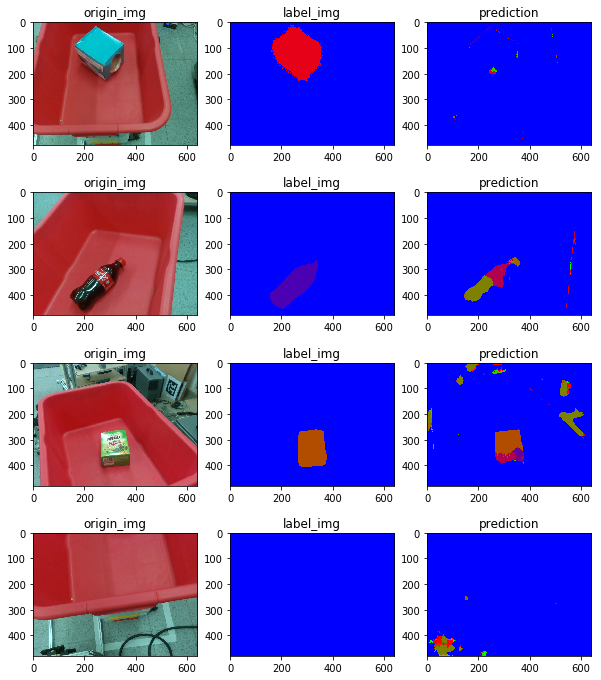

In [30]:
prediction("FCNs_box_gan_LAMDAID_1_batch12_epoch3_RMSprop_lr0.0001.pkl", dataiter)

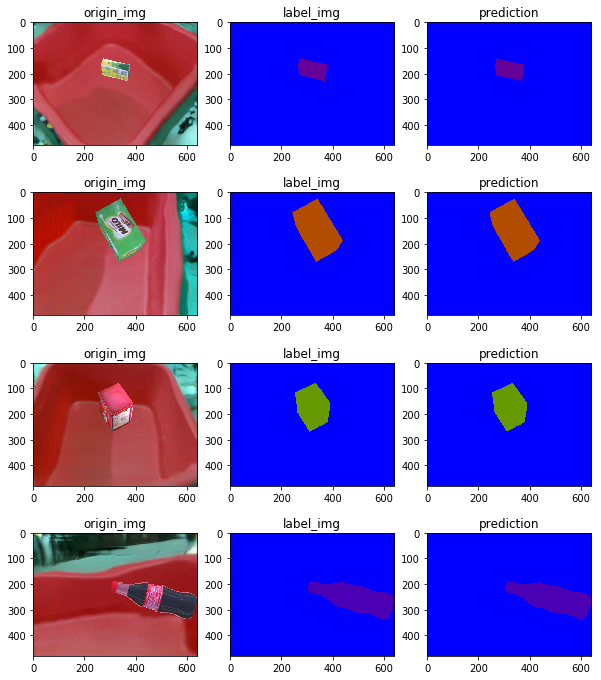

In [23]:
prediction("FCNs_box_gan_LAMDAID_1_batch12_epoch3_RMSprop_lr0.0001.pkl", testiter)